How well do our observations at 0.4$R_{26}$ match MaNGA's DR17 observations at the same radius?  And how well do our velocities observed at these radii reproduce the asymptotic rotational velocity?

In [10]:
import numpy as np
import numpy.ma as ma

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u
from astropy import wcs

import scipy.stats as stats
from scipy.optimize import minimize, curve_fit

import numdifftools as ndt

# from hyperfit.linfit import LinFit

# import corner

import os

# Path to RotationCurve libraries. Update as needed.
# rotcurvepath = os.path.join(os.environ['HOME'], 'desi/RotationCurves/spirals')
rotcurvepath = os.path.join(os.environ['HOME'], 'RotationCurves/spirals')
# rotcurvepath = os.path.join(os.environ['HOME'], 'Documents/Research/Rotation_curves/RotationCurves/spirals')

if not os.path.exists(rotcurvepath):
    raise FileNotFoundError(f'{rotcurvepath} does not exist.')

import sys
sys.path.insert(1, rotcurvepath)
from dark_matter_mass_v1 import rot_fit_BB

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.lines as mlines

In [11]:
mpl.rc('font', size=12)

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [12]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

c = const.c.to('km/s')

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
dv_sys = 7 # km/s
dz_sys = dv_sys/c.value

# Import data

## DESI

In [13]:
# tf_targets = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
# tf_targets = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tf_targets = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_iron_healpix.fits')


### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [14]:
tf_targets['ZERR_MOD'] = np.sqrt(tf_targets['ZERR']**2 + dz_sys**2)

## SGA

In [15]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
# SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')

In [16]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## SDSS MaNGA cross-match file

In [17]:
SGA_MaNGA = Table.read('MaNGA_SGA_crossmatch_2022-06-28.txt', format='ascii.commented_header')

SGA_MaNGA[:5]

plate,ifudsgn,plateifu,SGA_ID
int64,int64,str11,int64
8716,3703,8716-3703,927743
9086,6104,9086-6104,1003700
11967,1902,11967-1902,196166
8613,6104,8613-6104,376271
10001,3703,10001-3703,937846


## SDSS MaNGA best-fits

Nitya's fitting from 2025 on DR17

In [18]:
# MaNGA_fits = Table.read(#'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt', 
#                         'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD_ZPG16R_SFR_MZ.txt', # Ravi et al. (2023)
#                         format='ascii.commented_header')

MaNGA_fits = Table.read(#'master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt', 
                        'Elliptical_sphdisk_refitspirals_BPT_illustris_v11.fits', # Ravi et al. (in prep 2025)
                        format='fits')

'''
MaNGA_fits = Table.read('H_alpha_HIvel_BB_refit_ba.fits')
# MaNGA_fits = Table.read('/Users/kdouglass/Documents/Research/Rotation_curves/Nitya_Ravi/H_alpha_HIvel_BB_refit_ba.fits')
'''
MaNGA_fits[:5]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,Mvir,Mvir_err,star_sigma,star_sigma_err,dipole_moment,Rgal,vflag_VF,nsa_elpetro_log_mass,rabsmag,param_H2_R90,logHe,sphd_rho_c,sphd_rho_c_err,sphd_R_scale,sphd_R_scale_err,sphd_Sigma_d,sphd_Sigma_d_err,sphd_R_d,sphd_R_d_err,sphd_M_star,sphd_M_star_err,sphd_chi2,mhq_R_scale,mhq_R_scale_err,mhq_M_star,mhq_M_star_err,mhq_gamma,mhq_gamma_err,mhq_chi2,hq_R_scale,hq_R_scale_err,hq_M_star,hq_M_star_err,hq_chi2,sph_rho_c,sph_rho_c_err,sph_R_scale,sph_R_scale_err,sph_M_star,sph_M_star_err,sph_chi2,sum_M_star,sum_M_star_err,BPT_class,spiral_mask,elliptical_mask,Age_LW_Re_fit,Age_MW_Re_fit,ZH_LW_Re_fit,ZH_MW_Re_fit,M90_disk_h,M90_disk_err_h,sphd_M_star_err_h,sphd_M_star_h,V_R90,V_R90_err,e_M_star_R90,e_M_star_R90_err,e_M_star_R90_h,e_M_star_R90_err_h,v_eff,v_eff_err,logHI,logHI_err,HI_catalog,logHI_h,logHI_err_h,N2Ha,O3Hb,nsa_u_r,illustris_match,illustris_dist,illustris_u_r,illustris_Mstar,illustris_Mstar_Sal,illustris_Vmax,illustris_flag,illustris_MR90,MH2_S14_vol,MHI_S14_vol,MHtot
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,

# Calculate the rotational velocities for the DESI galaxies

## Separate the iron data into center and off-center observations

In [19]:
tf_targets['SKY_FIBER_DIST'] = 0.
tf_targets['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tf_targets['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tf_targets['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tf_targets['RA'][obs_idx], 
                             dec=tf_targets['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tf_targets['SKY_FIBER_DIST'][obs_idx] = sep2d
    tf_targets['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|██████████| 75152/75152 [03:01<00:00, 415.00it/s]


In [20]:
centers_boolean = tf_targets['SKY_FIBER_DIST_R26'] < 0.1

centers = tf_targets[centers_boolean]
axis = tf_targets[~centers_boolean]

## Clean the iron center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [21]:
good_centers = centers[(centers['DELTACHI2'] > 25) & (centers['ZWARN'] == 0)]

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [22]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [23]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

# weights = 1./(good_centers['ZERR']**2)
weights = 1/(good_centers['ZERR_MOD']**2)

for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    # Calculate the uncertainty in the center redshift
    if N_obs <= 1 or np.all(np.abs(good_centers['ZERR_MOD'][obs_idx]/good_centers['Z'][obs_idx]) < 0.05):
        SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    else:
        z_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            z_random[i] = rng.normal(loc=good_centers['Z'][obs_idx][i], 
                                     scale=good_centers['ZERR_MOD'][obs_idx][i], 
                                     size=N_samples)
            
        # avg_z_random = np.average(z_random, 
        #                           weights=weights[obs_idx, None]*np.ones(N_obs), 
        #                           axis=0)

        avg_z_random = np.average(z_random, 
                                  weights=weights[obs_idx]*np.ones(N_obs), 
                                  axis=0)
        
        SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)

100%|██████████| 70100/70100 [00:19<00:00, 3625.09it/s]


In [24]:
SGA_MaNGA['Z_DESI'] = np.nan
SGA_MaNGA['ZERR_DESI'] = np.nan
SGA_MaNGA['R26'] = np.nan
SGA_MaNGA['BA'] = np.nan
SGA_MaNGA['PA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[SGA_MaNGA['SGA_ID'][i]]
    
    # Set the redshift of this galaxy
    SGA_MaNGA['Z_DESI'][i] = SGA['Z_DESI'][SGA_idx]
    SGA_MaNGA['ZERR_DESI'][i] = SGA['ZERR_DESI'][SGA_idx]
    
    # Transfer R26 over to the SGA_MaNGA table
    SGA_MaNGA['R26'][i] = 0.5*SGA['D26'][SGA_idx]
    
    # Transfer b/a over to the SGA_MaNGA table
    SGA_MaNGA['BA'][i] = SGA['BA'][SGA_idx]
    
    # Transfer phi over to the SGA_MaNGA table
    SGA_MaNGA['PA'][i] = SGA['PA'][SGA_idx]

## Calculate the rotational velocity

In [25]:
axis['SKY_FIBER_DIST'] = 0.
axis['SKY_FIBER_DIST_R26'] = 0.
axis['V_ROT'] = np.nan
axis['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in tqdm(np.unique(centers['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis['RA'][obs_idx], 
                             dec=axis['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis['SKY_FIBER_DIST'][obs_idx] = sep2d.to('radian')
    axis['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # axis['V_ROT'][obs_idx] = c*(axis['Z'][obs_idx] - z_center)
    z_rot = (1 + axis['Z'][obs_idx])/(1 + z_center) - 1
    axis['V_ROT'][obs_idx] = c*z_rot

    # Calculate uncertainty in rotational velocity for each observation
    if np.all(np.abs(axis['ZERR_MOD'][obs_idx]/axis['Z'][obs_idx]) < 0.05) and (z_err_center/z_center < 0.05):
        # axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis['ZERR'][obs_idx]**2 + z_err_center**2)
        # axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + axis['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
        axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + axis['Z'][obs_idx])/(1 + z_center)**2))
    else:
        z_center_random = rng.normal(scale=z_err_center, 
                                     loc=z_center, 
                                     size=N_samples)

        z_rot_random = np.zeros((np.sum(obs_idx), N_samples))

        for i in range(np.sum(obs_idx)):
            
            z_axis_random = rng.normal(scale=axis['ZERR_MOD'][obs_idx][i], 
                                       loc=axis['Z'][obs_idx][i], 
                                       size=N_samples)

            z_rot_random[i] = (1 + z_axis_random)/(1 + z_center_random) - 1

        axis['V_ROT_ERR'][obs_idx] = np.std(np.abs(c*z_rot_random), axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

100%|██████████| 71533/71533 [04:15<00:00, 279.94it/s]


## Just keep those velocities measured at $0.4R_{26}$

In [26]:
axis_0p4 = axis[(axis['SKY_FIBER_DIST_R26'] > 0.36) & (axis['SKY_FIBER_DIST_R26'] < 0.5)]

## Remove "bad" galaxies

Those with
* $10 > V > 1000$ km/s
* $\Delta V / V_{min} < 5$
* $i < 25^\circ$

In [27]:
axis_0p4_goodV = axis_0p4[(np.abs(axis_0p4['V_ROT']) < 1000) & (np.abs(axis_0p4['V_ROT']) > 10)]

In [28]:
good_deltaV = np.ones(len(axis_0p4_goodV), dtype=bool)

for sga_id in tqdm(np.unique(axis_0p4_goodV['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_0p4_goodV['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(axis_0p4_goodV['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(axis_0p4_goodV['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(axis_0p4_goodV['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(axis_0p4_goodV['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(axis_0p4_goodV['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(axis_0p4_goodV['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            '''
            print(sga_id)
            print(diff_matrix_norm)
            print(1/v_norm_min.data)
            print(v_norm_max.data)
            print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
            ''';
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = axis_0p4_goodV['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(axis_0p4_goodV['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(axis_0p4_goodV['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(axis_0p4_goodV['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    '''
                    print(sga_id)
                    print(diff_matrix_norm)
                    print(good_axis_inComa[['TARGETID', 'V_ROT', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
                    ''';
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False
                    
axis_0p4_good = axis_0p4_goodV[good_deltaV]

100%|██████████| 10502/10502 [00:01<00:00, 8374.51it/s]


## Also remove those that have been visually inspected to be suspicious

In [29]:
VI_remove = Table.read('../../../TF/SV/fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(axis_0p4_good), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (axis_0p4_good['TARGETID'] == targetid)
    
VI_axis_0p4_good = axis_0p4_good[~remove_targets]

print(len(VI_axis_0p4_good), len(np.unique(VI_axis_0p4_good['SGA_ID'])))

15047 10492


## Add the rotational velocities to the SDSS MaNGA - SGA cross-match file

In [30]:
SGA_MaNGA['V_0p4R26'] = np.nan
SGA_MaNGA['V_0p4R26_ERR'] = np.nan

SGA_MaNGA['SKY_FIBER_DIST'] = np.nan

weights = 1./(VI_axis_0p4_good['V_ROT_ERR']**2)

for i in range(len(SGA_MaNGA)):
    
    # Does this galaxy have any observations?
    i_obs = VI_axis_0p4_good['SGA_ID'] == SGA_MaNGA['SGA_ID'][i]

    n_obs = np.sum(i_obs)
    
    if n_obs > 0:
        
        # Average all velocities at this radius
        SGA_MaNGA['V_0p4R26'][i] = np.average(np.abs(VI_axis_0p4_good['V_ROT'][i_obs]), 
                                               weights=weights[i_obs])

        # Calculate uncertainty in rotational velocity
        if n_obs == 1 or np.all(np.abs(VI_axis_0p4_good['V_ROT_ERR'][i_obs]/VI_axis_0p4_good['V_ROT'][i_obs]) < 0.05):
            SGA_MaNGA['V_0p4R26_ERR'][i] = np.sqrt(1./(n_obs*np.sum(weights[i_obs])))
        else:
            v_random = np.zeros((n_obs, N_samples))
            
            for j in range(n_obs):
                v_random[j] = rng.normal(scale=VI_axis_0p4_good['V_ROT_ERR'][i_obs][j], 
                                         loc=np.abs(VI_axis_0p4_good['V_ROT'][i_obs][j]), 
                                         size=N_samples)
                
            v_avg_random = np.average(np.abs(v_random), 
                                      weights=weights[i_obs, None]*np.ones(N_samples), 
                                      axis=0)
            SGA_MaNGA['V_0p4R26_ERR'][i] = np.std(v_avg_random)
        
        # Copy over the distance from the center for this observation
        SGA_MaNGA['SKY_FIBER_DIST'][i] = np.average(VI_axis_0p4_good['SKY_FIBER_DIST'][i_obs])

In [31]:
SGA_MaNGA[np.isfinite(SGA_MaNGA['V_0p4R26'])].show_in_notebook()

idx,plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p4R26,V_0p4R26_ERR,SKY_FIBER_DIST
0,9045,3702,9045-3702,29152,0.033320236763565,2.3939603751845863e-05,0.31793898344039917,0.6588062047958374,168.80343627929688,136.65409210450042,6.940032089871912,3.6993878682781195e-05
1,8615,1901,8615-1901,1265162,0.0197616666129208,2.3375717984689988e-05,0.2447134554386139,0.9234866499900818,75.16405487060547,142.94634563209866,11.418264283967268,2.8473704612431607e-05
2,7958,3702,7958-3702,1279893,0.0370122558474312,2.7450125440823022e-05,0.4380972981452942,0.6277525424957275,142.59364318847656,219.66869909615497,11.319532588717307,5.097493628082645e-05
3,11834,6104,11834-6104,1002687,0.0440140222262614,2.579129106517391e-05,0.2553322911262512,0.4506562352180481,161.87460327148438,151.4692170146641,6.4422480473568715,2.9709262142289764e-05
4,12081,12702,12081-12702,929612,0.0418290423138136,2.824227754875575e-05,0.3322809934616089,0.48097705841064453,146.14280700683594,160.37643562955543,12.249040671944103,3.866264776075021e-05
5,11824,12701,11824-12701,211567,0.0570328748289802,2.3897863101100734e-05,0.3941173851490021,0.7089425325393677,104.9497299194336,182.91185461293395,7.124092912713205,4.585764171544343e-05
6,11757,12701,11757-12701,1095337,0.0389700499520749,2.494294321251254e-05,0.22686167061328888,0.8023555874824524,45.64091110229492,94.92560511993292,10.81743178637418,2.639655409210207e-05
7,9031,12702,9031-12702,1205063,0.0403160857304091,2.9412651449673556e-05,0.2188577502965927,0.9376584887504578,28.06189727783203,23.909984493571635,6.167593426217005,2.546525592025893e-05
8,7981,12704,7981-12704,101204,0.0236797124276408,2.3762108601472596e-05,0.6746231317520142,0.21215707063674927,155.55569458007812,127.75123548311808,9.826476305655689,7.849596627315428e-05
9,7960,12705,7960-12705,1113259,0.0295822962278875,2.3451087596322265e-05,0.6513879895210266,0.551964282989502,159.84117126464844,196.65128928146345,10.627464043984531,7.579243214069017e-05


### save table of good velocities

In [33]:
SGA_MaNGA[np.isfinite(SGA_MaNGA['V_0p4R26'])].write('Y1_PV_TF_MaNGA_match.fits', format='fits', overwrite=True)

**Visual Inspection**

* Galaxies with no data
    * failed T-type cut: 9862-12704 (T-type=-0.46)
    * failed smoothness cut:  8951-3704, 11835-6103, 11024-6102
      
* Too much data masked: 8999-6103, 9032-12703
* Merger: 11865-6102
* Bad fits: 8144-3703, 8335-12704, 8977-12704, 9498-12703, 10224-9101, 10497-6103, 11828-12705, 11865-1902, 11949-12702, 11978-12701, 12506-12701, 12512-3701, 12769-12705 
* Successfully refit: 12079-9101 (note mngtarg1 = 0, mngtarg3 > 0), 11955-3703 (note mngtarg1 = 0, mngtarg3 > 0),  '11835-12703', '11982-3702'

### temporarily set bad galaxies to have -999 vals

In [37]:
bad_gals = ['8999-6103', '9032-12703', '11865-6102', '8144-3703', 
            '8335-12704', '8977-12704', '9498-12703', '10224-9101', 
            '10497-6103', '11828-12705', '11865-1902', '11949-12702', 
            '11978-12701', '12506-12701', '12512-3701', '12769-12705']

for gal_ID in bad_gals:
    idx = np.where(MaNGA_fits['plateifu'] == gal_ID)[0]

    MaNGA_fits['v_max'][idx] = -999

## Add the MaNGA best-fit values to the table

In [38]:
SGA_MaNGA['Vmax_map'] = np.nan
SGA_MaNGA['Vmax_err_map'] = np.nan
SGA_MaNGA['Rturn_map'] = np.nan
SGA_MaNGA['alpha_map'] = np.nan

SGA_MaNGA['ba_map'] = np.nan
SGA_MaNGA['ba_err_map'] = np.nan
SGA_MaNGA['ba_NSA'] = np.nan

SGA_MaNGA['phi_map'] = np.nan
SGA_MaNGA['phi_err_map'] = np.nan
SGA_MaNGA['phi_NSA'] = np.nan

SGA_MaNGA['Z_NSA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    gal_id = SGA_MaNGA['plateifu'][i]
    
    # Find galaxy row in MaNGA fits table
    
    # plate_bool = MaNGA_fits['MaNGA_plate'] == SGA_MaNGA['plate'][i]
    # ifu_bool = MaNGA_fits['MaNGA_IFU'] == SGA_MaNGA['ifudsgn'][i]
    
    # i_fit = plate_bool & ifu_bool
    
    i_fit = MaNGA_fits['plateifu'] == SGA_MaNGA['plateifu'][i]
    
    # Copy best-fit parameter values from fit table to galaxy table
    if (np.sum(i_fit) > 0): #and (gal_id not in []):
        
        # SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['Vmax_map'][i_fit]
        # SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['Vmax_err_map'][i_fit]
        # SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['Rturn_map'][i_fit]
        # SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha_map'][i_fit]
        
        # SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba_map'][i_fit]
        # SGA_MaNGA['ba_err_map'][i] = MaNGA_fits['ba_err_map'][i_fit]
        # SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['NSA_ba'][i_fit]
        
        # SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi_map'][i_fit]
        # SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err_map'][i_fit]
        # SGA_MaNGA['phi_NSA'][i] = MaNGA_fits['NSA_phi'][i_fit]
        
        # SGA_MaNGA['Z_NSA'][i] = MaNGA_fits['NSA_redshift'][i_fit]
        
        SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['v_max'][i_fit]
        SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['v_max_err'][i_fit]
        SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['r_turn'][i_fit]
        SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha'][i_fit]
        
        SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba'][i_fit]
        SGA_MaNGA['ba_err_map'][i] = MaNGA_fits['ba_err'][i_fit]
        SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['nsa_elpetro_ba'][i_fit]
        
        SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi'][i_fit]
        SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err'][i_fit]
        SGA_MaNGA['phi_NSA'][i] = MaNGA_fits['nsa_elpetro_phi'][i_fit]
        
        SGA_MaNGA['Z_NSA'][i] = MaNGA_fits['nsa_z'][i_fit]
        

# Flip all -99 values to NaN
for col_name in SGA_MaNGA.colnames:
    
    bad_values = SGA_MaNGA[col_name] == -999
    
    if np.any(bad_values):
        SGA_MaNGA[col_name][bad_values] = np.nan

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:1383: UserWarning: Warning: converting a masked element to nan.
  self.data[index] = value
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/astropy/table/column.py:351: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)


In [39]:
good_V = np.isfinite(SGA_MaNGA['Vmax_map']) & np.isfinite(SGA_MaNGA['V_0p4R26'])

print(np.sum(good_V))

260


In [40]:
# Also remove those galaxies from the final sample that have V(R26) < 0.9Vmax, and have Vmax > 1000 km/s

# 1 - Convert R26 to kpc for each galaxy
dist_to_galaxy = SGA_MaNGA['Z_DESI']*c/H0
R26_kpc = dist_to_galaxy.to('kpc')*np.tan((SGA_MaNGA['R26']*u.arcmin).to(u.rad))

# 2 - Compute V(R26)
SGA_MaNGA['Vfit_R26'] = rot_fit_BB(R26_kpc.data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])

# 3 - Filter out those with V(R26) < 0.9Vmax
goodVmax = SGA_MaNGA['Vfit_R26'] >= 0.9*SGA_MaNGA['Vmax_map']

# 4 - Filter out those with Vmax > 1000 km/s
lowVmax = SGA_MaNGA['Vmax_map'] < 1000.
'''
# 5 - Filter out those with alpha > 99
good_alpha = SGA_MaNGA['alpha_map'] < 99.

# 6 - Filter out those with large uncertainties in Vmax
goodVmax2 = SGA_MaNGA['Vmax_err_map']/SGA_MaNGA['Vmax_map'] <= 2
''';

# #7 - Filter out those with i_SGA < 25 (requirement of TF sample)
cosi2 = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
cosi2[cosi2 < 0] = 0
cosi2_max = np.cos(25*np.pi/180)**2
goodi = cosi2 <= cosi2_max

final_sample = good_V & goodVmax & lowVmax & goodi #& good_alpha & goodVmax2

In [41]:
SGA_MaNGA[final_sample]
#SGA_MaNGA[good_V & ~goodVmax]

plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p4R26,V_0p4R26_ERR,SKY_FIBER_DIST,Vmax_map,Vmax_err_map,Rturn_map,alpha_map,ba_map,ba_err_map,ba_NSA,phi_map,phi_err_map,phi_NSA,Z_NSA,Vfit_R26
int64,int64,str11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
9045,3702,9045-3702,29152,0.033320236763565,2.3939603751845863e-05,0.31793898344039917,0.6588062047958374,168.80343627929688,136.65409210450042,6.940032089871912,3.6993878682781195e-05,210.50452801297985,1.8353976854896468,0.7066919287420622,0.9111401871299377,0.8234098343647784,0.001601497928492459,0.70429,170.71749392618315,0.02929622324244995,168.862,0.0333513,190.3331387248938
7958,3702,7958-3702,1279893,0.0370122558474312,2.7450125440823022e-05,0.4380972981452942,0.6277525424957275,142.59364318847656,219.66869909615497,11.319532588717307,5.097493628082645e-05,242.9211676900525,0.1875765246066455,1.365763143678639,3.082085057706107,0.678949712986619,0.0005240797629047349,0.719594,321.0557249418591,0.015508704418586036,138.715,0.0370471,242.86257806758167
11834,6104,11834-6104,1002687,0.0440140222262614,2.579129106517391e-05,0.2553322911262512,0.4506562352180481,161.87460327148438,151.4692170146641,6.4422480473568715,2.9709262142289764e-05,232.29567853040538,3.5372042573275575,1.6157067061530481,2.2182435957133957,0.7980107504115111,0.005971267624381377,0.7131611,162.8144980146715,0.1086854487008954,160.61732,0.044045065,230.40036546090042
12081,12702,12081-12702,929612,0.0418290423138136,2.824227754875575e-05,0.3322809934616089,0.48097705841064453,146.14280700683594,160.37643562955543,12.249040671944103,3.866264776075021e-05,195.42432287880288,1.3346281500087767,1.3198023994720334,1.1216729306540982,0.6541854019632092,0.003249980121659414,0.5533,324.31771976680415,0.10032848698407756,145.41603,0.041768476,181.99386853987892
11824,12701,11824-12701,211567,0.0570328748289802,2.3897863101100734e-05,0.3941173851490021,0.7089425325393677,104.9497299194336,182.91185461293395,7.124092912713205,4.585764171544343e-05,213.21030009683315,0.37995901749603017,3.2421984975912386,4.107502810453571,0.7709798023865316,0.000980767615119872,0.79347116,277.7050698514268,0.022168037157852916,112.61641,0.05706307,213.17829474867375
11757,12701,11757-12701,1095337,0.0389700499520749,2.494294321251254e-05,0.22686167061328888,0.8023555874824524,45.64091110229492,94.92560511993292,10.81743178637418,2.639655409210207e-05,139.8589447091876,3.48141965647591,1.9702654263831174,3.565549293643847,0.9012611974513942,0.005217860723617648,0.87782425,44.92909939483331,0.11326059485829489,45.205704,0.038932998,139.55779164329874
7981,12704,7981-12704,101204,0.0236797124276408,2.3762108601472596e-05,0.6746231317520142,0.21215707063674927,155.55569458007812,127.75123548311808,9.826476305655689,7.849596627315428e-05,159.1567380226344,0.13691373686525377,2.8083087564742604,1.6877761392736441,0.36337010470901626,0.00020157436744451266,0.285965,337.22365652250346,0.03310175035335541,156.571,0.0236902,153.15717996989034
7960,12705,7960-12705,1113259,0.0295822962278875,2.3451087596322265e-05,0.6513879895210266,0.551964282989502,159.84117126464844,196.65128928146345,10.627464043984531,7.579243214069017e-05,194.06595728938112,0.21087117746507697,2.3302865700141315,2.624290777832418,0.6399453742603087,0.0006785044524424655,0.629551,159.1139132530324,0.018325754980222722,158.271,0.0295939,193.65329363350423
8445,3701,8445-3701,359006,0.024329632534749998,2.418247000502217e-05,0.5927615165710449,0.5653266906738281,79.91859436035156,227.77196234826673,4.992754689997025,6.897093920507438e-05,235.56827164846956,0.2042262642010385,1.3840725335767259,1.6401305847941747,0.5794203426895572,0.0004318173801497677,0.762906,80.52428442267995,0.016331096073052564,111.421,0.0243152,231.8005403392289


# Compare DESI's observed rotational velocities at 0.4$R_{26}$ with $V(0.4R_{26})$ from the best-fit to MaNGA

### 1) Convert $R_{26}$ to kpc for each galaxy

In [42]:
dist_to_galaxy = SGA_MaNGA['Z_DESI']*c/H0

p4R26_kpc = dist_to_galaxy.to('kpc')*np.tan(SGA_MaNGA['SKY_FIBER_DIST'])

### 2) Compute $V(0.4R_{26})$ based on the best-fits

In [43]:
SGA_MaNGA['Vfit_0p4R26'] = rot_fit_BB(p4R26_kpc.data, 
                                       [SGA_MaNGA['Vmax_map'], 
                                        SGA_MaNGA['Rturn_map'], 
                                        SGA_MaNGA['alpha_map']])

#### Compute the uncertainty in the velocity at this location

In [44]:
SGA_MaNGA['Vfit_0p4R26_err'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    if np.isfinite(SGA_MaNGA['Vmax_map'][i]) and np.isfinite(SGA_MaNGA['V_0p4R26'][i]):
        
        gal_ID = str(SGA_MaNGA['plate'][i]) + '-' + str(SGA_MaNGA['ifudsgn'][i])

        try:
            # Hessian = np.load('/global/u1/k/kadglass/RotationCurves/spirals/DRP_map_Hessians/dr17/' + gal_ID + '_Hessian.npy')
            Hessian = np.load('/pscratch/sd/n/nravi/dr17_Hessians/' + gal_ID + '_Hessian.npy')
            hess_inv = 2*np.linalg.inv(Hessian)

            N_samples = 10000

            random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['Vmax_map'][i], 
                                                                SGA_MaNGA['Rturn_map'][i], 
                                                                SGA_MaNGA['alpha_map'][i]], 
                                                          cov=hess_inv[-3:,-3:], 
                                                          size=N_samples)

            # Remove bad samples (those with negative values for any of the parameters)
            is_good_random = (random_sample[:,0] > 0) & (random_sample[:,1] > 0) & (random_sample[:,2] > 0)
            good_randoms = random_sample[is_good_random, :]

            # Calculate values of curve at this location
            y_sample = rot_fit_BB(R26_kpc[i].value, [good_randoms[:,0], 
                                                     good_randoms[:,1], 
                                                     good_randoms[:,2]])

            SGA_MaNGA['Vfit_0p4R26_err'][i] = np.std(y_sample, axis=0)
        except (FileNotFoundError, np.linalg.LinAlgError) as error:
            print(gal_ID, error)

/tmp/ipykernel_925938/1160019302.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['Vmax_map'][i],


### 3) Plot

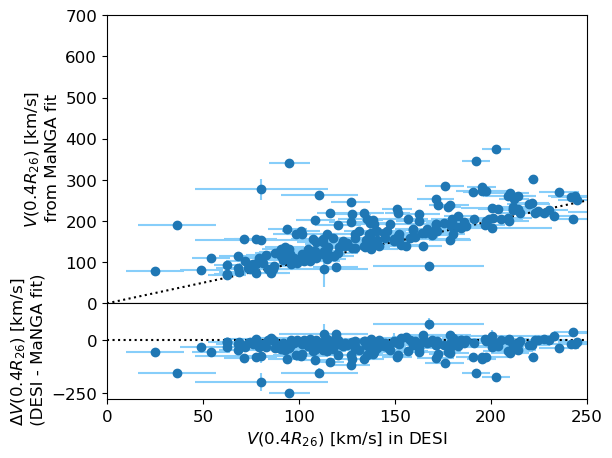

In [45]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['V_0p4R26'][final_sample], SGA_MaNGA['Vfit_0p4R26'][final_sample], 
             yerr=SGA_MaNGA['Vfit_0p4R26_err'][final_sample], 
             xerr=SGA_MaNGA['V_0p4R26_ERR'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(0, 700)
plt.xlim(0, 250)

plt.ylabel('$V(0.4R_{26})$ [km/s]\n from MaNGA fit')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['V_0p4R26'][final_sample], SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vfit_0p4R26'][final_sample], 
             xerr=SGA_MaNGA['V_0p4R26_ERR'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_0p4R26_err'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 250, linestyles='dotted', colors='k')

plt.xlim(0, 250)

plt.xlabel('$V(0.4R_{26})$ [km/s] in DESI')
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s]\n (DESI - MaNGA fit)');

# plt.savefig('../Figures/SV/fuji_MaNGA-V0p33_comparison.eps', dpi=300);
# plt.savefig('fuji_MaNGA-V0p33_comparison.eps', dpi=300);

#### Save figure data to file for DESI publication

In [48]:
plot_v033 = fits.Column(name='DESI_V', array=SGA_MaNGA['V_0p4R26'], format='E', unit='km/s')
plot_v033_sigma = fits.Column(name='DESI_Verr', array=SGA_MaNGA['V_0p4R26_ERR'], format='E', unit='km/s')

plot_vmax = fits.Column(name='MaNGA_Vmax', array=SGA_MaNGA['Vmax_map'], format='E', unit='km/s')
plot_vmax_sigma = fits.Column(name='MaNGA_Vmax_err', array=SGA_MaNGA['Vmax_err_map'], format='E', unit='km/s')

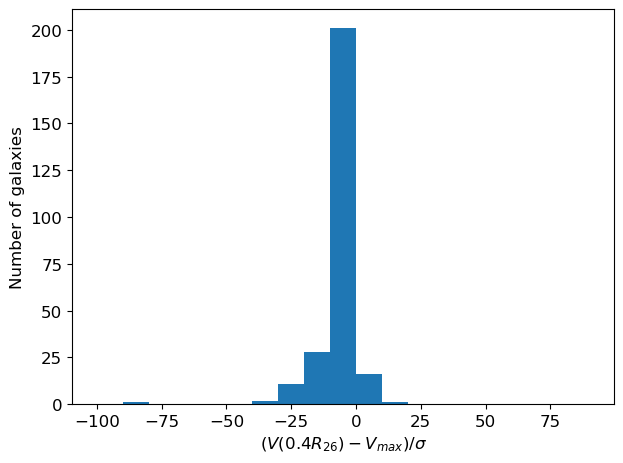

In [49]:
plt.figure(tight_layout=True)

plt.hist((SGA_MaNGA['V_0p4R26'] - SGA_MaNGA['Vmax_map'])/np.sqrt(SGA_MaNGA['V_0p4R26_ERR']**2 + SGA_MaNGA['Vmax_err_map']**2), 
         #bins=np.arange(-500, 100, 50), 
         bins=np.arange(-100, 100, 10),
         #histtype='step', 
         #linewidth=3
        )

#plt.xlabel('($V(0.33R_{26}) - V_{max}$) [km/s]')
plt.xlabel('($V(0.4R_{26}) - V_{max}$)/$\sigma$')
plt.ylabel('Number of galaxies');

#plt.savefig('../Figures/SV/fuji_MaNGA_Vmax_pull.png', dpi=300);

## How do these residuals depend on the inclination angle?

### Pull distribution

In [50]:
diff_norm = (SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vfit_0p4R26'][final_sample])/np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_0p4R26_err'][final_sample]**2)

avg = np.nanmean(diff_norm)

std_dev = np.nanstd(diff_norm)

print(avg, std_dev)

-2.8183331570750307 4.037858731999082


In [51]:
# Segev: Normalize Gaussian by area under the curve (to figure out what the amplitude should be)
# The area is equal to the number of galaxies, so 
area = np.sum(np.isfinite(SGA_MaNGA['Vmax_map'][final_sample]) & np.isfinite(SGA_MaNGA['V_0p4R26'][final_sample]))

#amplitude = area/(std_dev*np.sqrt(2*np.pi))
# scipy.stats.norm.pdf is already normalized by sigma and the sqrt of 2pi, so we just need to scale it by the area.

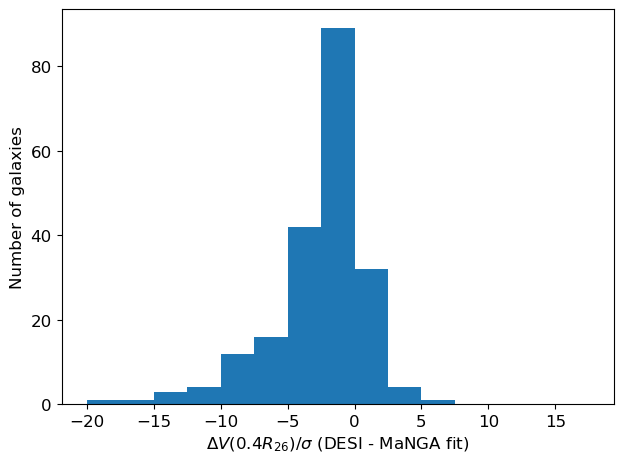

In [52]:
plt.figure(tight_layout=True)

plt.hist(diff_norm, 
         #bins=np.arange(-400, 100, 50), 
         bins=np.arange(-20, 20, 2.5), 
         #density=True
        )
'''
x = np.arange(-9, 9, 0.1)
plt.plot(x, area*stats.norm.pdf(x, avg, std_dev))

plt.annotate('$\mu$ = {0:.2f}\n$\sigma$ = {1:.2f}'.format(avg, std_dev), 
             (6, 14))

plt.xlim((-9, 9))
'''
#plt.xlabel('$\Delta V(0.33R_{26})$ [km/s] (DESI - MaNGA fit)')
plt.xlabel('$\Delta V(0.4R_{26})/\sigma$ (DESI - MaNGA fit)')
plt.ylabel('Number of galaxies');

#plt.savefig('../Figures/SV/fuji_MaNGA_V0p33_pull.png', dpi=300);

## Repeat with correcting for differences in $i$ and $\phi$ between MaNGA fits and SGA values

In [53]:
delta_pa = np.abs((SGA_MaNGA['phi_map']%180.) - SGA_MaNGA['PA'])
delta_pa[delta_pa > 90.] = 180. - delta_pa[delta_pa > 90.]
SGA_MaNGA['delta_phi'] = delta_pa

cosi2_sga = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
cosi2_manga = (SGA_MaNGA['ba_map']**2 - q0**2)/(1 - q0**2)

cosi2_sga[cosi2_sga < 0] = 0.
cosi2_manga[cosi2_manga < 0] = 0.

DESI_corrected = (1./np.cos(delta_pa*np.pi/180.))*(np.sin(np.arccos(np.sqrt(cosi2_sga)))/np.sin(np.arccos(np.sqrt(cosi2_manga))))*SGA_MaNGA['V_0p4R26']

SGA_MaNGA['Vfit_corr_0p4R26'] = np.cos(delta_pa*np.pi/180.)*(np.sin(np.arccos(np.sqrt(cosi2_manga)))/np.sin(np.arccos(np.sqrt(cosi2_sga))))*SGA_MaNGA['Vfit_0p4R26']

/tmp/ipykernel_925938/615132541.py:13: RuntimeWarning: divide by zero encountered in true_divide
  SGA_MaNGA['Vfit_corr_0p4R26'] = np.cos(delta_pa*np.pi/180.)*(np.sin(np.arccos(np.sqrt(cosi2_manga)))/np.sin(np.arccos(np.sqrt(cosi2_sga))))*SGA_MaNGA['Vfit_0p4R26']


### Calculate the uncertainty in the adjusted MaNGA fit value

In [54]:
SGA_MaNGA['Vfit_corr_0p4R26_err'] = np.nan

# Convert b/a to i (to match what is in the Hessians)
SGA_MaNGA['i_map'] = np.arccos(np.sqrt((SGA_MaNGA['ba_map']**2 - q0**2)/(1 - q0**2)))

for i in range(len(SGA_MaNGA)):
    
    if np.isfinite(SGA_MaNGA['Vmax_map'][i]) and np.isfinite(SGA_MaNGA['V_0p4R26'][i]):
        
        gal_ID = str(SGA_MaNGA['plate'][i]) + '-' + str(SGA_MaNGA['ifudsgn'][i])

        try:
            # Hessian = np.load('/global/u1/k/kadglass/RotationCurves/spirals/DRP_map_Hessians/dr17/' + gal_ID + '_Hessian.npy')
            Hessian = np.load('/pscratch/sd/n/nravi/dr17_Hessians/' + gal_ID + '_Hessian.npy')

            hess_inv_all = 2*np.linalg.inv(Hessian)
            
            # Reconstruct the inverse Hessian to contain just the parameters that we need
            hess_inv = np.zeros((5,5))
            hess_inv[-4:,-4:] = hess_inv_all[-4:,-4:] # copies phi, Vmax, Rturn, and alpha
            hess_inv[0,0] = hess_inv_all[1,1] # copies i
            hess_inv[0,-4:] = hess_inv_all[1,-4:] # copies off-diagonal elements for i
            hess_inv[-4:,0] = hess_inv_all[-4:,1] # copies off-diagonal elements for i

            N_samples = 10000

            random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['i_map'][i],
                                                                SGA_MaNGA['phi_map'][i], 
                                                                SGA_MaNGA['Vmax_map'][i], 
                                                                SGA_MaNGA['Rturn_map'][i], 
                                                                SGA_MaNGA['alpha_map'][i]], 
                                                          cov=hess_inv, 
                                                          size=N_samples)

            # Remove bad samples (those with negative values for any of the parameters)
            is_good_random = np.all(random_sample > 0, axis=1)
            good_randoms = random_sample[is_good_random, :]

            # Calculate values of curve at this location
            y_sample = rot_fit_BB(R26_kpc[i].value, [good_randoms[:,-3], 
                                                     good_randoms[:,-2], 
                                                     good_randoms[:,-1]])
            
            # Adjust for differences in i and phi
            delta_pa_sample = np.abs((good_randoms[:,1]%180.) - SGA_MaNGA['PA'][i])
            delta_pa_sample[delta_pa_sample > 90.] = 180. - delta_pa_sample[delta_pa_sample > 90.]
            
            y_sample = np.cos(delta_pa_sample*np.pi/180)*(np.sin(good_randoms[:,0])/np.sin(np.arccos(np.sqrt(cosi2_sga[i]))))*y_sample

            SGA_MaNGA['Vfit_corr_0p4R26_err'][i] = np.std(y_sample, axis=0)
            
        except (FileNotFoundError, np.linalg.LinAlgError) as error:
            print(gal_ID, error)

/tmp/ipykernel_925938/95579810.py:27: RuntimeWarning: covariance is not positive-semidefinite.
  random_sample = np.random.multivariate_normal(mean=[SGA_MaNGA['i_map'][i],


### Compare corrected velocity at 0.4R26 as a function of $\Delta \phi$

/tmp/ipykernel_925938/714488445.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figures/Delta_phi/MaNGA_iron_deltaV0p4R26-vs-deltaPhi_wHist_20250731.png',


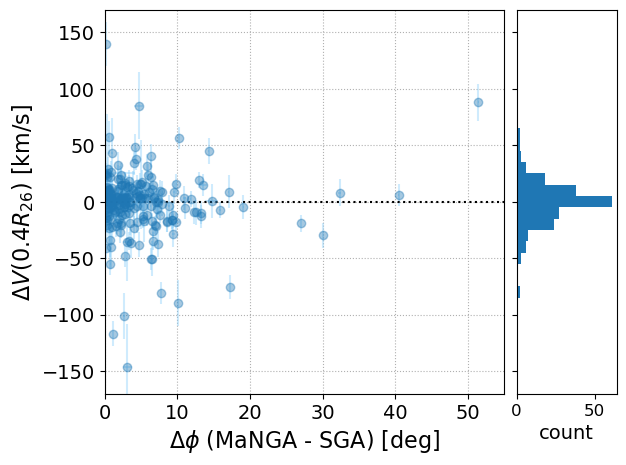

In [60]:
fig = plt.figure(tight_layout=True)

gs = fig.add_gridspec(1, 2, width_ratios=(4, 1), left=0.15, right=0.95, bottom=0.15, top=0.95, wspace=0.05)

ax = fig.add_subplot(gs[0, 0])
ax.errorbar(np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
            SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p4R26'][final_sample],#(np.sin(np.arccos(np.sqrt(cosi2_manga[final_sample])))/np.sin(np.arccos(np.sqrt(cosi2_sga[final_sample]))))*SGA_MaNGA['Vfit_0p33R26'][final_sample], 
            xerr=SGA_MaNGA['phi_err_map'][final_sample], 
            yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_corr_0p4R26_err'][final_sample]**2), 
            fmt='o', 
            alpha=0.4,
            ecolor='lightskyblue')
ax.hlines(0, 0., 90., linestyles='dotted', colors='k')

ax.grid(ls=':')

ax.set_xlim(0, 55)
ax.set_ylim(-170, 170)

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
ax.set_ylabel('$\Delta V(0.4R_{26})$ [km/s]', fontsize=16)


ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)
hist_counts, hist_bin_edges,_ = ax_histy.hist(SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p4R26'][final_sample], 
                                              bins=np.arange(-115, 115, 10), 
                                              orientation='horizontal')

ax_histy.tick_params(axis='y', labelleft=False)

ax_histy.set_xlabel('count', fontsize=14);

# # plt.savefig('../../Figures/MaNGA_dr17/MaNGA_fuji_deltaV0p33R26-vs-deltaPhi_20240228.png', dpi=150);
plt.savefig('Figures/Delta_phi/MaNGA_iron_deltaV0p4R26-vs-deltaPhi_wHist_20250731.png', 
            dpi=150, 
            facecolor='None');

**examine galaxies with V > 150**

* 8145-1902 (SGA ID 501697): IFU only covers central region of galaxy
* 8651-6104 (SGA ID 1081444): significant overlap between center fiber placement and 0.4R26 fibers (galaxy size is comparable to fiber size)
* 8942-12901 (SGA ID 661558): significant overlap between center fiber placement and 0.4R26 fibers (galaxy size is comparable to fiber size)
* 10514-12705 (SGA ID 1093020): MaNGA fit affected by AGN (see https://academic.oup.com/mnras/article/489/1/855/5545601)


In [80]:
SGA_MaNGA[np.logical_and(np.abs(SGA_MaNGA['V_0p4R26'] - SGA_MaNGA['Vfit_corr_0p4R26'])>100, final_sample)]

plate,ifudsgn,plateifu,SGA_ID,Z_DESI,ZERR_DESI,R26,BA,PA,V_0p4R26,V_0p4R26_ERR,SKY_FIBER_DIST,Vmax_map,Vmax_err_map,Rturn_map,alpha_map,ba_map,ba_err_map,ba_NSA,phi_map,phi_err_map,phi_NSA,Z_NSA,Vfit_R26,Vfit_0p4R26,Vfit_0p4R26_err,delta_phi,Vfit_corr_0p4R26,Vfit_corr_0p4R26_err,i_map
int64,int64,str11,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8145,1902,8145-1902,501697,0.0271919858198798,2.343994021054985e-05,0.2557879090309143,0.3876526355743408,81.53166961669922,94.9334329071923,10.658469860247733,2.976227535358501e-05,344.1567569847021,0.5471053930660107,0.5687254034815163,2.8015442950639375,0.821361836838372,0.0006074582347409608,0.653233,82.67886540710664,0.020608110819560713,86.6153,0.0271584,343.994918927143,342.0708618980673,0.5512220325671936,1.147195790407423,211.62888929044934,0.15357541757613,0.6213947254111319
8651,6104,8651-6104,1081444,0.0470094516496003,2.4763509783260144e-05,0.31363970041275024,0.4851541519165039,3.137979745864868,80.38681322020128,34.64973402327248,3.649363515177596e-05,292.4356648028105,24.815648185846708,5.061598279869479,11.424379492374642,0.6969966267406557,0.03741511700309204,0.597074,1.2546921017570067e-12,0.5806250182007425,8.97458,0.0470156,292.43505842636034,277.325801995366,25.225942881318407,3.1379797458636136,227.0797755817336,16.388028506321366,0.8210488863908167
8942,1901,8942-1901,661558,0.0460718078976561,2.5310936241332457e-05,0.3144594728946686,0.35252445936203003,63.86140441894531,110.59252893289788,20.169975591744358,3.65890215014409e-05,274.2526972818132,2.3493631731779883,2.011612180797496,2.431171679225034,0.6580109287632181,0.003844631472184605,0.456743,241.19482213659944,0.14464303780161608,66.0669,0.0461316,272.9681377248131,263.0700709688506,2.131221411702858,2.666582282345871,211.454282583731,1.8381059496056997,0.8765497386683002
10514,12705,10514-12705,1093020,0.0238036083521299,2.3749517851174105e-05,1.1060404777526855,0.1594744324684143,170.86993408203125,333.1538508839204,19.351194162428758,0.00012869365982579243,218.53999977289976,0.5492435499664092,0.44262132472678367,0.8286341937459899,0.29933984371810274,7.703186306884621e-05,0.279171,171.03282898933222,0.07411537306912304,178.639,0.0234383,208.93952620802384,198.92557096408177,0.4703410172121763,0.16289490730096645,193.71726571113552,0.4936941169047062,1.3414787918139024


In [95]:
MaNGA_fits[MaNGA_fits['plateifu'] == '8145-1902']

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag,nsa_elpetro_absmag,nsa_elpetro_amivar,nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction,nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux,nsa_petro_flux_ivar,nsa_elpetro_flux,nsa_elpetro_flux_ivar,nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux,nsa_sersic_flux_ivar,smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map,logHI_R90,Mvir,Mvir_err,star_sigma,star_sigma_err,dipole_moment,Rgal,vflag_VF,nsa_elpetro_log_mass,rabsmag,param_H2_R90,logHe,sphd_rho_c,sphd_rho_c_err,sphd_R_scale,sphd_R_scale_err,sphd_Sigma_d,sphd_Sigma_d_err,sphd_R_d,sphd_R_d_err,sphd_M_star,sphd_M_star_err,sphd_chi2,mhq_R_scale,mhq_R_scale_err,mhq_M_star,mhq_M_star_err,mhq_gamma,mhq_gamma_err,mhq_chi2,hq_R_scale,hq_R_scale_err,hq_M_star,hq_M_star_err,hq_chi2,sph_rho_c,sph_rho_c_err,sph_R_scale,sph_R_scale_err,sph_M_star,sph_M_star_err,sph_chi2,sum_M_star,sum_M_star_err,BPT_class,spiral_mask,elliptical_mask,Age_LW_Re_fit,Age_MW_Re_fit,ZH_LW_Re_fit,ZH_MW_Re_fit,M90_disk_h,M90_disk_err_h,sphd_M_star_err_h,sphd_M_star_h,V_R90,V_R90_err,e_M_star_R90,e_M_star_R90_err,e_M_star_R90_h,e_M_star_R90_err_h,v_eff,v_eff_err,logHI,logHI_err,HI_catalog,logHI_h,logHI_err_h,N2Ha,O3Hb,nsa_u_r,illustris_match,illustris_dist,illustris_u_r,illustris_Mstar,illustris_Mstar_Sal,illustris_Vmax,illustris_flag,illustris_MR90,MH2_S14_vol,MHI_S14_vol,MHtot
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64,float64,float64[7],float64[7],float64[7],float64[7],float64,float64,float64,float64,float64[7],float64[7],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,

In [98]:
1/(299792.458*0.0271584/100 * 1000 * np.tan((1/60)*(1/60)*(np.pi/180)))*2.758425799070272

6.988139336462302

In [100]:
0.512*0.4*60

12.288

### Save figure data for paper

In [61]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR1'
hdr['FIGURE'] = 4

empty_primary = fits.PrimaryHDU(header=hdr)

In [62]:
scatter_hdu = fits.BinTableHDU(data=Table([np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
                                           SGA_MaNGA['phi_err_map'][final_sample], 
                                           SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p4R26'][final_sample], 
                                           np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_corr_0p4R26_err'][final_sample]**2)], 
                                          names=['DELTA_PHI', 'DELTA_PHI_ERR', 'DELTA_V', 'DELTA_V_ERR']), 
                               name='SCATTER')

hist_hdu = fits.BinTableHDU(data=Table([hist_bin_edges[:-1], hist_counts], 
                                       names=['BIN_EDGE', 'N']), 
                            name='HIST')

hdul = fits.HDUList([empty_primary, scatter_hdu, hist_hdu])

# hdul.writeto('../../TF/SV/paper_figures/Fig4/fig4_data.fits', overwrite=True)
hdul.writeto('Figures/Delta_phi/fig4_data.fits', overwrite=True)


### Compare DESI V(0.4R26) to MaNGA fit after correction

/tmp/ipykernel_925938/2456031613.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('Figures/Delta_v/Delta_v_scatter/iron_MaNGA-V0p4_comparison_corrected_20250731.png',


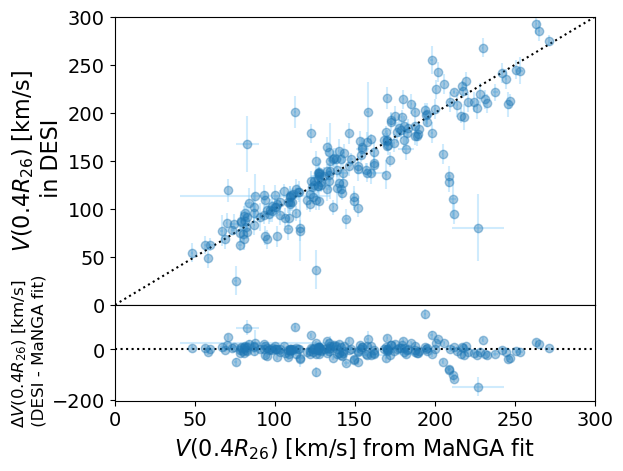

In [65]:
fig = plt.figure(tight_layout=True)

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['Vfit_corr_0p4R26'][final_sample], SGA_MaNGA['V_0p4R26'][final_sample], 
             xerr=SGA_MaNGA['Vfit_corr_0p4R26_err'][final_sample], 
             yerr=SGA_MaNGA['V_0p4R26_ERR'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue',
            alpha=0.4)
plt.plot([0, 1000], [0, 1000], 'k:')

plt.xlim(0, 300)
plt.ylim(0, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.ylabel('$V(0.4R_{26})$ [km/s]\n in DESI', fontsize=16)

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['Vfit_corr_0p4R26'][final_sample], SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vfit_corr_0p4R26'][final_sample], 
             xerr=SGA_MaNGA['Vfit_corr_0p4R26_err'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vfit_corr_0p4R26_err'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue',
            alpha=0.4)
plt.hlines(0, 0, 350, linestyles='dotted', colors='k')

plt.xlim(0, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$V(0.4R_{26})$ [km/s] from MaNGA fit', fontsize=16)
plt.ylabel('$\Delta V(0.4R_{26})$ [km/s]\n (DESI - MaNGA fit)');

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_comparison_corrected_20250617.png', 
#             dpi=150, 
#             facecolor='None');


plt.savefig('Figures/Delta_v/Delta_v_scatter/iron_MaNGA-V0p4_comparison_corrected_20250731.png', 
            dpi=150, 
            facecolor='None');

#### Save figure data for paper

In [66]:
hdr2 = fits.Header()

hdr2['DESI_DR'] = 'Y1'
hdr2['FIGURE'] = 5

empty_primary2 = fits.PrimaryHDU(header=hdr2)

In [67]:
vel_hdu = fits.BinTableHDU(data=SGA_MaNGA['Vfit_corr_0p4R26', 'Vfit_corr_0p4R26_err', 'V_0p4R26', 'V_0p4R26_ERR'][final_sample], 
                           name='SCATTER')
vel_hdu.columns['Vfit_corr_0p4R26'].name = 'V_MaNGA'
vel_hdu.columns['Vfit_corr_0p4R26_err'].name = 'V_MaNGA_ERR'
vel_hdu.columns['V_0p4R26'].name = 'V_DESI'
vel_hdu.columns['V_0p4R26_ERR'].name = 'V_DESI_ERR'

### Compute the perpendicular distance to $y = x$ for each point

See Segev's notebook, `line_hist.ipynb`, for the calculation.

In [68]:
dist = (SGA_MaNGA['V_0p4R26'] - SGA_MaNGA['Vfit_corr_0p4R26']) / np.sqrt(2)

In [69]:
# Normalize these distances by the "expected" value at y = x
dist_norm = dist / (0.5*(SGA_MaNGA['V_0p4R26'] + SGA_MaNGA['Vfit_corr_0p4R26']))

# Normalize these distances by the "total" uncertainty
dist_norm_sigma = dist / np.sqrt(SGA_MaNGA['Vfit_corr_0p4R26_err']**2 + SGA_MaNGA['V_0p4R26_ERR']**2)

In [70]:
sigma_dist = np.std(dist[final_sample])
sigma_dist_norm = np.std(dist_norm[final_sample])
sigma_dist_norm_sigma = np.std(dist_norm_sigma[final_sample])

print(sigma_dist)
print(sigma_dist_norm)
print(sigma_dist_norm_sigma)

20.2091903085605
0.14885211550137464
1.572282424743293


##### Distribution of perpendicular distances

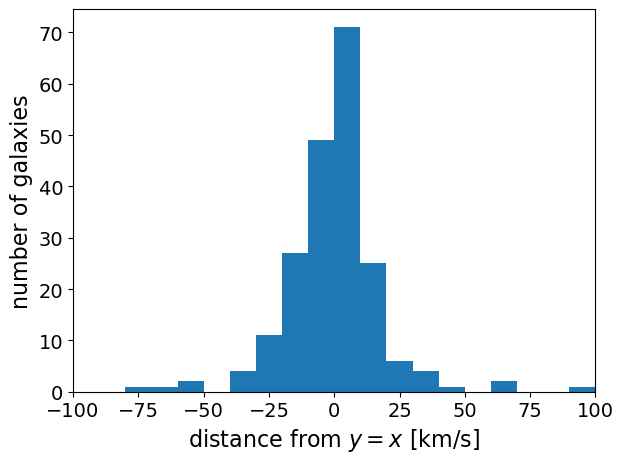

In [71]:
plt.figure(tight_layout=True)

plt.hist(dist[final_sample], bins=np.arange(-80, 110, 10))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim(-100, 100)

plt.xlabel('distance from $y = x$ [km/s]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diff_hist.eps', dpi=150);

##### Distribution of perpendicular distances normalized by $V$

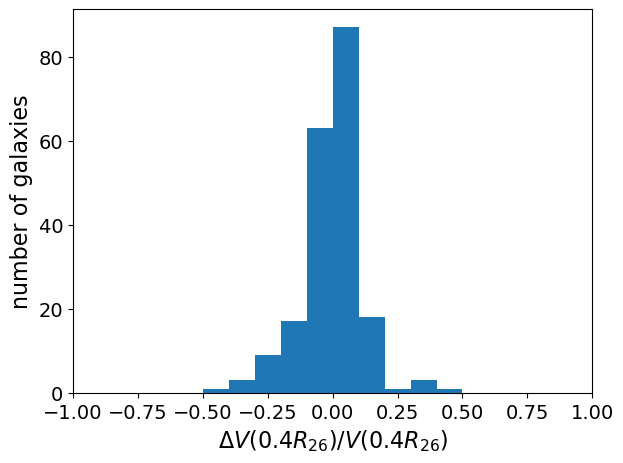

In [72]:
plt.figure(tight_layout=True)

plt.hist(dist_norm[final_sample], bins=np.arange(-0.5, 1.25, 0.1))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-1, 1])

plt.xlabel('$\Delta V(0.4R_{26}) / V(0.4R_{26})$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnorm_hist.eps', dpi=150);

##### Distribution of perpendicular distances normalized by $\sigma$

\begin{equation}
  \sigma^2 = \sigma_\text{DESI}^2 + \sigma_\text{MaNGA}^2
\end{equation}

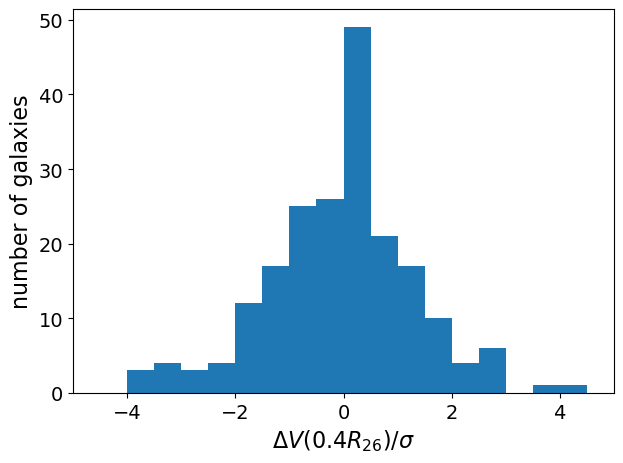

In [73]:
plt.figure(tight_layout=True)

plt.hist(dist_norm_sigma[final_sample], bins=np.arange(-5, 5, 0.5))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-5, 5])

plt.xlabel('$\Delta V(0.4R_{26}) / \sigma$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnormsigma_hist.eps', dpi=150);

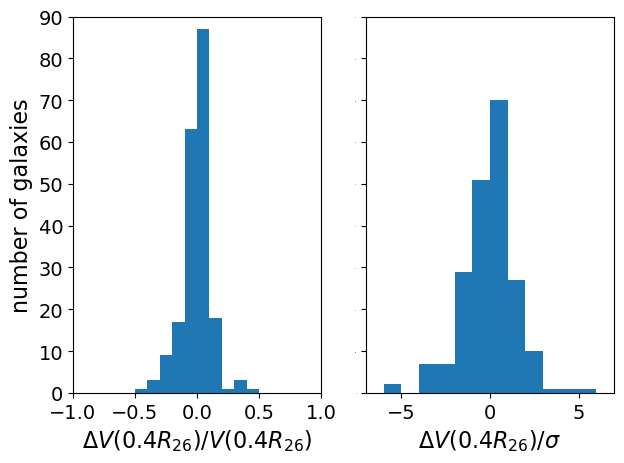

In [74]:
plt.figure(tight_layout=True)


plt.subplot(121)

norm_counts, norm_bin_edges,_ = plt.hist(dist_norm[final_sample], 
                                         bins=np.arange(-0.5, 1.25, 0.1))

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlim([-1, 1])
plt.ylim([0, 90])

plt.xlabel('$\Delta V(0.4R_{26}) / V(0.4R_{26})$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16)


plt.subplot(122)

sigma_counts, sigma_bin_edges,_ = plt.hist(dist_norm_sigma[final_sample], 
                                           bins=np.arange(-10, 10, 1))

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='y', labelsize=0)

plt.xlim([-7, 7])
plt.ylim([0, 90])

plt.xlabel('$\Delta V(0.4R_{26}) / \sigma$', fontsize=16);

# plt.savefig('../../Figures/MaNGA_dr17/fuji_MaNGA-V0p33_diffnorm-sigma-dVsys_hists_20250617.png', 
#             dpi=150, 
#             facecolor='None');


plt.savefig('Figures/Delta_v/Delta_v_hist/iron_MaNGA-V0p4_diffnorm-sigma-dVsys_hists_20250731.png', 
            dpi=150, 
            facecolor='None');

##### Save figure data for paper

In [75]:
norm_hdu = fits.BinTableHDU(data=Table([norm_bin_edges[:-1], norm_counts], 
                                       names=['BIN_EDGE', 'N']),
                            name='NORM_HIST')

sigma_hdu = fits.BinTableHDU(data=Table([sigma_bin_edges[:-1], sigma_counts], 
                                        names=['BIN_EDGE', 'N']),
                             name='HIST_SIGMA')

In [76]:
hdul2 = fits.HDUList([empty_primary2, vel_hdu, norm_hdu, sigma_hdu])

# hdul2.writeto('../../TF/SV/paper_figures/Fig5/fig5_data.fits')
hdul2.writeto('Figures/Delta_v/fig5_data.fits', overwrite=True)

# Compare $V(0.4R_{26})$ to $V_{\rm max}$ (From SV)

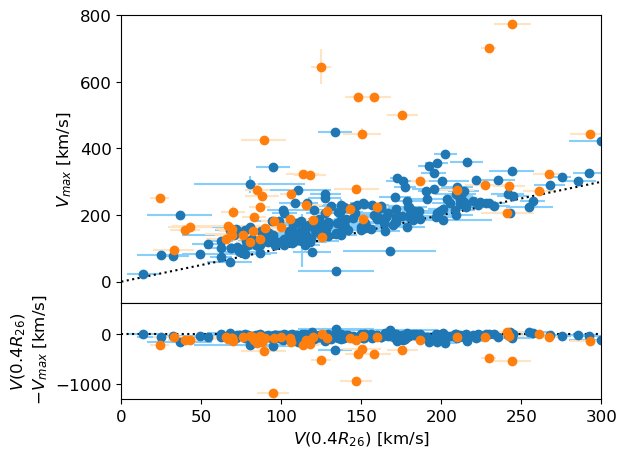

In [280]:
fig = plt.figure()

frame1 = fig.add_axes((0.2, 0.35, 0.75, 0.6))

plt.errorbar(SGA_MaNGA['V_0p4R26'][final_sample], SGA_MaNGA['Vmax_map'][final_sample], 
             yerr=SGA_MaNGA['Vmax_err_map'][final_sample], 
             xerr=SGA_MaNGA['V_0p4R26_ERR'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue')
plt.errorbar(SGA_MaNGA['V_0p4R26'][good_V & (~goodVmax | ~lowVmax)], SGA_MaNGA['Vmax_map'][good_V & (~goodVmax | ~lowVmax)], 
             yerr=SGA_MaNGA['Vmax_err_map'][good_V & (~goodVmax | ~lowVmax)], 
             xerr=SGA_MaNGA['V_0p4R26_ERR'][good_V & (~goodVmax | ~lowVmax)], 
             fmt='o', 
             ecolor='bisque')
plt.plot([0, 1000], [0, 1000], 'k:')

plt.ylim(ymax=800)
plt.xlim(0, 300)

plt.ylabel('$V_{max}$ [km/s]')

frame1.axes.get_xaxis().set_visible(False)


frame2 = fig.add_axes((0.2, 0.15, 0.75, 0.2))

plt.errorbar(SGA_MaNGA['V_0p4R26'][final_sample], SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['V_0p4R26_ERR'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.errorbar(SGA_MaNGA['V_0p4R26'][good_V & (~goodVmax | ~lowVmax)], SGA_MaNGA['V_0p4R26'][good_V & (~goodVmax | ~lowVmax)] - SGA_MaNGA['Vmax_map'][good_V & (~goodVmax | ~lowVmax)], 
             xerr=SGA_MaNGA['V_0p4R26_ERR'][good_V & (~goodVmax | ~lowVmax)], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][good_V & (~goodVmax | ~lowVmax)]**2 + SGA_MaNGA['Vmax_err_map'][good_V & (~goodVmax | ~lowVmax)]**2), 
             fmt='o', 
             ecolor='bisque')
plt.hlines(0, 0, 350, linestyles='dotted', colors='k')

plt.xlim(0, 300)
#plt.ylim(-500, 150)

plt.ylabel('$V(0.4R_{26})$\n $- V_{max}$ [km/s]')
plt.xlabel('$V(0.4R_{26})$ [km/s]');

#plt.savefig('../Figures/SV/fuji_MaNGA-Vmax_comparison.eps', dpi=300);

## How do these residuals depend on redshift?

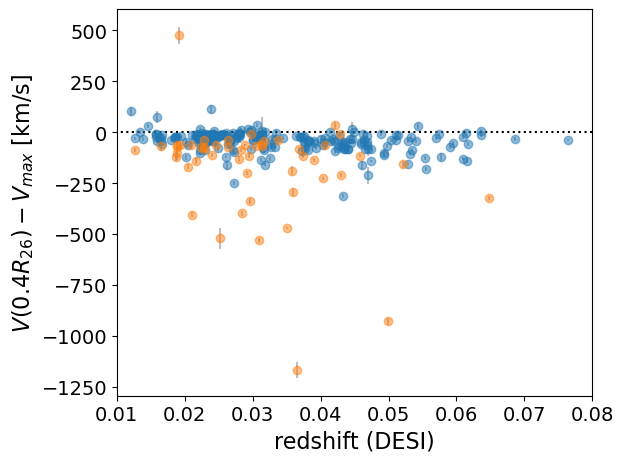

In [281]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray')
plt.errorbar(SGA_MaNGA['Z_DESI'][good_V & (~goodVmax | ~lowVmax)], 
             SGA_MaNGA['V_0p4R26'][good_V & (~goodVmax | ~lowVmax)] - SGA_MaNGA['Vmax_map'][good_V & (~goodVmax | ~lowVmax)], 
             xerr=SGA_MaNGA['ZERR_DESI'][good_V & (~goodVmax | ~lowVmax)], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][good_V & (~goodVmax | ~lowVmax)]**2 + SGA_MaNGA['Vmax_err_map'][good_V & (~goodVmax | ~lowVmax)]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray')
# plt.scatter(SGA_MaNGA['Z_DESI'][final_sample], 
#             SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
#             c=SGA_MaNGA['BA'][final_sample], 
#             vmin=0.2, vmax=1, 
#             zorder=1)
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k', zorder=2)
# plt.colorbar(label='b/a (SGA)')

plt.xlim(0.01, 0.08)
#plt.ylim(-600, 75)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('redshift (DESI)', fontsize=16)
plt.ylabel('$V(0.4R_{26}) - V_{max}$ [km/s]', fontsize=16);

#plt.savefig('../Figures/SV/MaNGA_fuji_deltaVmax-vs-z_20230823.png', dpi=150);

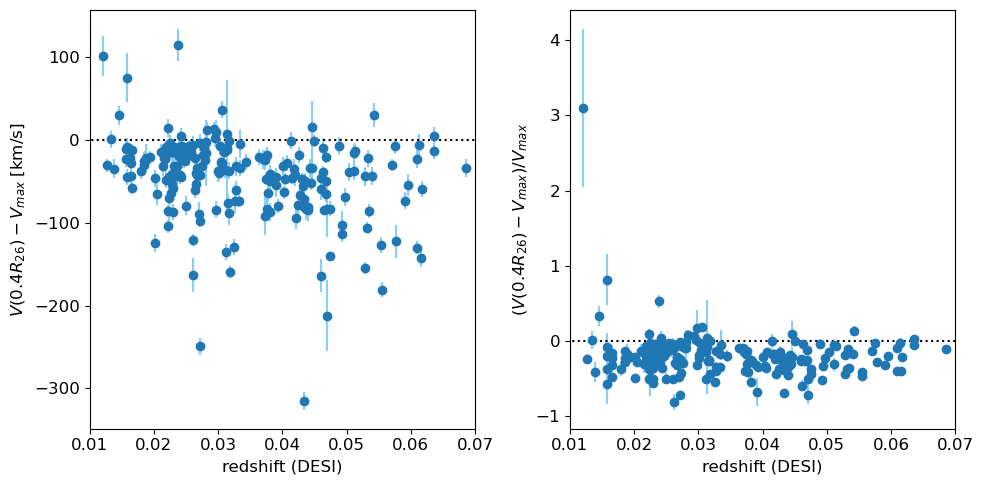

In [282]:
plt.figure(tight_layout=True, figsize=(10,5))

plt.subplot(121)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

plt.xlim(0.01, 0.07)
#plt.ylim(-325, 75)

plt.xlabel('redshift (DESI)')
plt.ylabel('$V(0.4R_{26}) - V_{max}$ [km/s]')


plt.subplot(122)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             (SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + (SGA_MaNGA['V_0p4R26'][final_sample]/SGA_MaNGA['Vmax_map'][final_sample])**2 * SGA_MaNGA['Vmax_err_map'][final_sample]**2)/SGA_MaNGA['Vmax_map'][final_sample], 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

plt.xlim(0.01, 0.07)
#plt.ylim(-1, 0.6)

plt.xlabel('redshift (DESI)')
plt.ylabel('($V(0.4R_{26}) - V_{max}$)/$V_{max}$');

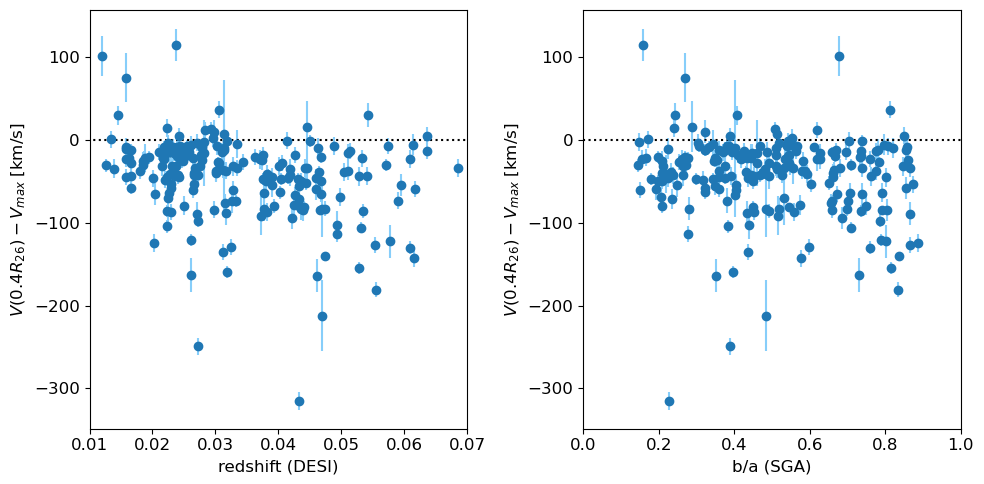

In [283]:
plt.figure(tight_layout=True, figsize=(10,5))

plt.subplot(121)

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

plt.xlim(0.01, 0.07)
#plt.ylim(-325, 75)

plt.xlabel('redshift (DESI)')
plt.ylabel('$V(0.4R_{26}) - V_{max}$ [km/s]')


plt.subplot(122)

plt.errorbar(SGA_MaNGA['BA'][final_sample], 
             SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             ecolor='lightskyblue')
plt.hlines(0, 0, 1, linestyles='dotted', colors='k')

plt.xlim(0, 1)
#plt.ylim(-1, 0.6)

plt.xlabel('b/a (SGA)')
plt.ylabel('$V(0.4R_{26}) - V_{max}$ [km/s]');

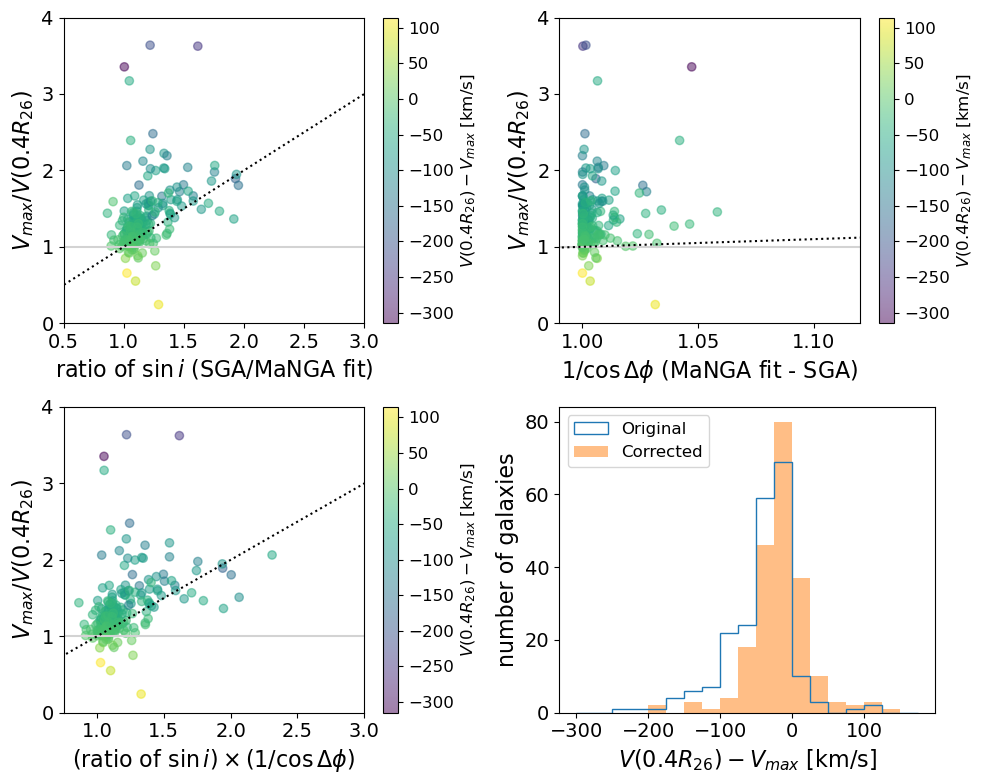

In [284]:
plt.figure(tight_layout=True, figsize=(10,8))

plt.subplot(221)

cosi2_sga = (SGA_MaNGA['BA']**2 - q0**2)/(1 - q0**2)
cosi2_manga = (SGA_MaNGA['ba_map']**2 - q0**2)/(1 - q0**2)

cosi2_sga[cosi2_sga < 0] = 0.
cosi2_manga[cosi2_manga < 0] = 0.

plt.scatter(np.sin(np.arccos(np.sqrt(cosi2_sga[final_sample])))/np.sin(np.arccos(np.sqrt(cosi2_manga[final_sample]))), 
             SGA_MaNGA['Vmax_map'][final_sample]/SGA_MaNGA['V_0p4R26'][final_sample], 
             c=SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample],
             alpha=0.5)
plt.hlines(1, 0, 5, colors='lightgray')
plt.plot([0,5], [0,5], 'k:')

plt.xlim(0.5, 3)
plt.ylim(0, 4)

plt.colorbar(label='$V(0.4R_{26}) - V_{max}$ [km/s]')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('ratio of $\sin i$ (SGA/MaNGA fit)', fontsize=16)
plt.ylabel('$V_{max}/V(0.4R_{26})$', fontsize=16);


plt.subplot(222)

delta_pa = np.abs((SGA_MaNGA['phi_map']%180.) - SGA_MaNGA['PA'])
delta_pa[delta_pa > 90.] = 180. - delta_pa[delta_pa > 90.]

plt.scatter(1./np.cos(delta_pa[final_sample]*np.pi/180.), 
             SGA_MaNGA['Vmax_map'][final_sample]/SGA_MaNGA['V_0p4R26'][final_sample], 
             c=SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample],
             alpha=0.5)
plt.hlines(1, 0, 5, colors='lightgray')
plt.plot([0,2], [0,2], 'k:')

plt.xlim(0.99, 1.12)
plt.ylim(0, 4)

plt.colorbar(label='$V(0.4R_{26}) - V_{max}$ [km/s]')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$1/\cos \Delta \phi$ (MaNGA fit - SGA)', fontsize=16)
plt.ylabel('$V_{max}/V(0.4R_{26})$', fontsize=16);


plt.subplot(223)

plt.scatter((1./np.cos(delta_pa[final_sample]*np.pi/180.))*(np.sin(np.arccos(np.sqrt(cosi2_sga[final_sample])))/np.sin(np.arccos(np.sqrt(cosi2_manga[final_sample])))), 
             SGA_MaNGA['Vmax_map'][final_sample]/SGA_MaNGA['V_0p4R26'][final_sample], 
             c=SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample],
             alpha=0.5)
plt.hlines(1, 0, 5, colors='lightgray')
plt.plot([0,5], [0,5], 'k:')

plt.xlim(0.75, 3)
plt.ylim(0, 4)

plt.colorbar(label='$V(0.4R_{26}) - V_{max}$ [km/s]')

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel(r'(ratio of $\sin i) \times (1/\cos \Delta \phi$)', fontsize=16)
plt.ylabel('$V_{max}/V(0.4R_{26})$', fontsize=16);


plt.subplot(224)

corrected_residuals = (1./np.cos(delta_pa*np.pi/180.))*(np.sin(np.arccos(np.sqrt(cosi2_sga)))/np.sin(np.arccos(np.sqrt(cosi2_manga))))*SGA_MaNGA['V_0p4R26'] - SGA_MaNGA['Vmax_map']

plt.hist(SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], bins=np.arange(-300, 200, 25), histtype='step', label='Original')
plt.hist(corrected_residuals[final_sample], alpha=0.5, bins=np.arange(-300, 200, 25), label='Corrected')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$V(0.4R_{26}) - V_{max}$ [km/s]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


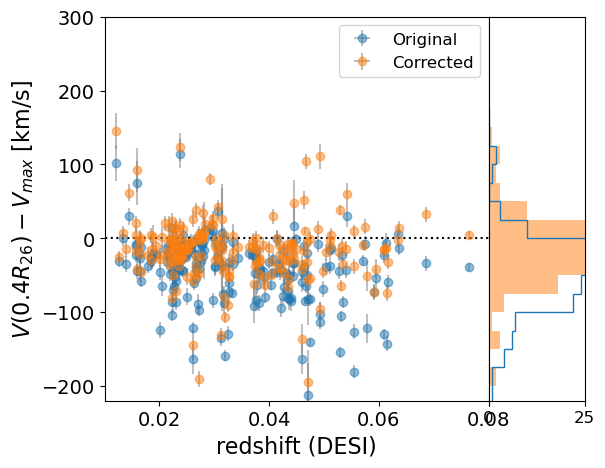

In [285]:
fig = plt.figure(tight_layout=True)

frame1 = fig.add_axes((0.2, 0.15, 0.6, 0.8))

plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Original')
plt.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             corrected_residuals[final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Corrected')
plt.hlines(0, 0, 0.08, linestyles='dotted', colors='k', zorder=2)

plt.xlim(0.01, 0.08)
plt.ylim(-220, 300)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.legend()

plt.xlabel('redshift (DESI)', fontsize=16)
plt.ylabel('$V(0.4R_{26}) - V_{max}$ [km/s]', fontsize=16)


frame2 = fig.add_axes((0.8, 0.15, 0.15, 0.8))

plt.hist(SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], bins=np.arange(-500, 200, 25), histtype='step', orientation='horizontal', label='Original')
plt.hist(corrected_residuals[final_sample], alpha=0.5, bins=np.arange(-500, 200, 25), orientation='horizontal', label='Corrected')

plt.xlim(0, 25)
plt.ylim(-220, 300)

frame2.axes.get_yaxis().set_visible(False);

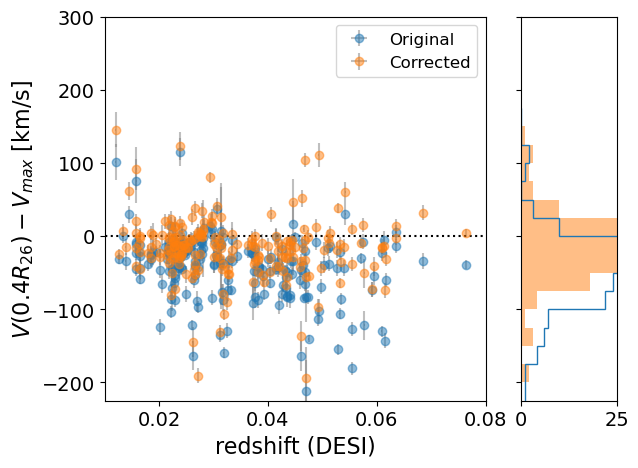

In [286]:
fig = plt.figure(tight_layout=True)

gs = fig.add_gridspec(1, 2, width_ratios=(4, 1), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.15)

ax = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[0, 1], sharey=ax)


ax.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Original')
ax.errorbar(SGA_MaNGA['Z_DESI'][final_sample], 
             corrected_residuals[final_sample], 
             xerr=SGA_MaNGA['ZERR_DESI'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray', 
             label='Corrected')
ax.hlines(0, 0, 0.08, linestyles='dotted', colors='k')

ax.set_xlim(0.01, 0.08)
ax.set_ylim(-225, 300)

ax.tick_params(axis='both', which='major', labelsize=14)

ax.legend()

ax.set_xlabel('redshift (DESI)', fontsize=16)
ax.set_ylabel('$V(0.4R_{26}) - V_{max}$ [km/s]', fontsize=16)


ax_histy.hist(SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], bins=np.arange(-500, 200, 25), histtype='step', orientation='horizontal', label='Original')
ax_histy.hist(corrected_residuals[final_sample], alpha=0.5, bins=np.arange(-500, 200, 25), orientation='horizontal', label='Corrected')

ax_histy.set_xlim(0, 25)
ax_histy.set_ylim(-225, 300)

ax_histy.tick_params(axis='y', labelleft=False)

ax_histy.tick_params(axis='x', which='major', labelsize=14);

## How do these residuals compare to that from the MaNGA fits?

### Compute $\Delta V$ for each MaNGA fit

In [287]:
# 1 - Convert R26 to kpc for each galaxy
dist_to_galaxy_NSA = SGA_MaNGA['Z_NSA']*c/H0
R26_kpc_NSA = dist_to_galaxy_NSA.to('kpc')*np.tan((SGA_MaNGA['R26']*u.arcmin).to(u.rad))

SGA_MaNGA['Vfit_0p33R26'] = rot_fit_BB((0.33*R26_kpc_NSA).data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])
SGA_MaNGA['Vfit_0p4R26'] = rot_fit_BB((0.4*R26_kpc_NSA).data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])

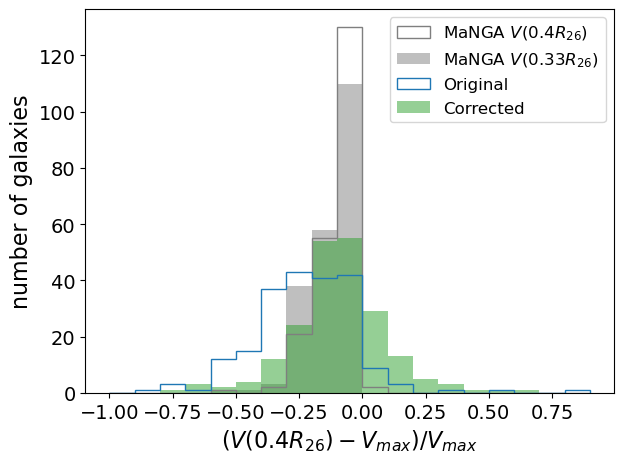

In [289]:
bins = np.arange(-1, 1, 0.1)

plt.figure(tight_layout=True)

plt.hist((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, edgecolor='tab:gray', histtype='step', label='MaNGA $V(0.4R_{26})$')
plt.hist((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, facecolor='gray', alpha=0.5, label='MaNGA $V(0.33R_{26})$')
plt.hist((SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, edgecolor='tab:blue', histtype='step', label='Original')
plt.hist(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample], 
         alpha=0.5, bins=bins, density=False, facecolor='tab:green', label='Corrected')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('($V(0.4R_{26}) - V_{max}$)/$V_{max}$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

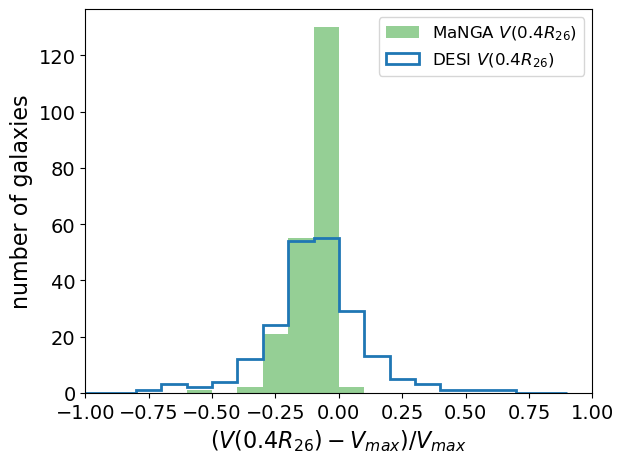

In [290]:
# Same figure as above, but for paper
bins = np.arange(-1, 1, 0.1)

plt.figure(tight_layout=True)

plt.hist((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, facecolor='tab:green', alpha=0.5, label='MaNGA $V(0.4R_{26})$')
plt.hist(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample], 
         bins=bins, density=False, edgecolor='tab:blue', histtype='step', linewidth=2,
         label='DESI $V(0.4R_{26})$')

plt.xlim(-1, 1)

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('($V(0.4R_{26}) - V_{max}$)/$V_{max}$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

# plt.savefig('../../Figures/SV/fuji_MaNGA_Vdiff_comparison.png', dpi=150);

In [291]:
mean_MaNGA = np.mean((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
mean_corrected = np.mean(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

print('MaNGA mean (0.4R26): %.3f' % mean_MaNGA)
print('Corrected mean: %.3f' % mean_corrected)

MaNGA mean (0.4R26): -0.087
Corrected mean: -0.063


In [292]:
std_MaNGA = np.std((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
std_corrected = np.std(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

print('MaNGA std (0.4R26): %.3f' % std_MaNGA)
print('Corrected std: %.3f' % std_corrected)
print('DESI effect (0.4R26): %.3f' % np.sqrt(std_corrected**2 - std_MaNGA**2))

MaNGA std (0.4R26): 0.081
Corrected std: 0.380
DESI effect (0.4R26): 0.371


In [293]:
def fit_func(x, a, mu, sigma, c):
    '''
    Gaussian function
    '''
    return a*stats.norm.pdf(x, loc=mu, scale=sigma) + c


hist_manga0p33,_ = np.histogram((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                bins=bins)
hist_manga0p4,_ = np.histogram((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                               bins=bins)
hist_original,_ = np.histogram((SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                               bins=bins)
hist_corrected,_ = np.histogram(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample], 
                                bins=bins)

centers = bins[:-1] + (bins[1] - bins[0])

p0_manga0p33 = [np.max(hist_manga0p33), 
                np.mean((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
                np.std((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
                -0.1]
p0_manga0p4 = [np.max(hist_manga0p4), 
               np.mean((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
               np.std((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
                -0.1]
p0_original = [np.max(hist_original), 
               np.mean((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
               np.std((SGA_MaNGA['V_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample]), 
               -0.3]
p0_corrected = [np.max(hist_corrected), 
                np.mean(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample]), 
                np.std(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample]), 
                -0.1]

p1_manga0p33,_ = curve_fit(fit_func, centers, hist_manga0p33, p0_manga0p33)
p1_manga0p4,_ = curve_fit(fit_func, centers, hist_manga0p4, p0_manga0p4)
p1_original,_ = curve_fit(fit_func, centers, hist_original, p0_original)
p1_corrected,_ = curve_fit(fit_func, centers, hist_corrected, p0_corrected)

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [294]:
print('MaNGA std (0.33R26): %.3f' % p1_manga0p33[2])
print('MaNGA std (0.4R26): %.3f' % p1_manga0p4[2])
print('Corrected std: %.3f' % p1_corrected[2])
print('DESI effect (0.33R26): %.3f' % np.sqrt(p1_corrected[2]**2 - p1_manga0p33[2]**2))

MaNGA std (0.33R26): 0.048
MaNGA std (0.4R26): 0.045
Corrected std: 0.127
DESI effect (0.33R26): 0.117


In [295]:
def rms(x):
    '''
    Calculate the RMS of x
    '''
    return np.sqrt(np.sum(x**2)/len(x))


RMS_manga0p33 = rms((SGA_MaNGA['Vfit_0p33R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
RMS_manga0p4 = rms((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
RMS_original = rms((SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
RMS_corrected = rms(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

In [296]:
print('MaNGA rms (0.33R26): %.3f' % RMS_manga0p33)
print('MaNGA rms (0.4R26): %.3f' % RMS_manga0p4)
print('Corrected rms: %.3f' % RMS_corrected)
print('DESI effect (0.4R26): %.3f' % np.sqrt(RMS_corrected**2 - RMS_manga0p33**2))

MaNGA rms (0.33R26): 0.154
MaNGA rms (0.4R26): 0.119
Corrected rms: 0.385
DESI effect (0.4R26): 0.353


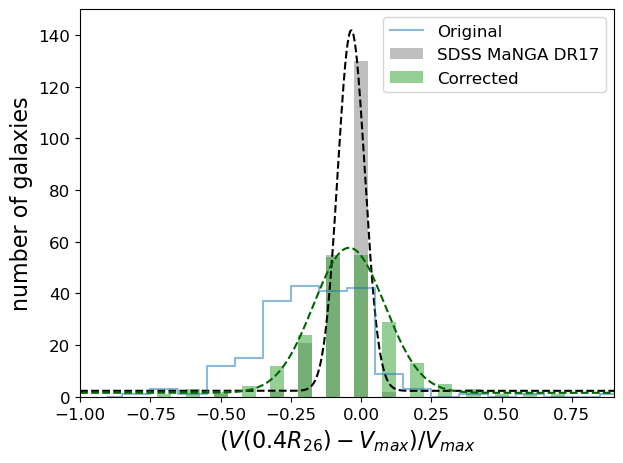

In [301]:
x = np.linspace(bins[0], bins[-1], 1000)

plt.figure(tight_layout=True)

plt.bar(centers, hist_manga0p4, width=0.05, facecolor='gray', alpha=0.5, label='SDSS MaNGA DR17')#label='MaNGA $V(0.33R_{26})$')
plt.plot(x, fit_func(x, *p1_manga0p33), '--k')

# plt.step(centers, hist_manga0p4, c='gray', where='mid', label='MaNGA $V(0.4R_{26})$')
# plt.plot(x, fit_func(x, *p1_manga0p4), ':', c='tab:gray')

plt.step(centers, hist_original, c='tab:blue', alpha=0.5, where='mid', label='Original')
plt.plot(x, fit_func(x, *p1_original), ':', c='tab:blue')

plt.bar(centers, hist_corrected, width=0.05, facecolor='tab:green', alpha=0.5, label='Corrected')
plt.plot(x, fit_func(x, *p1_corrected), '--', c='darkgreen')

plt.xlim(bins[0], bins[-1])
plt.ylim(0, 150)

plt.legend()

plt.xlabel('($V(0.4R_{26}) - V_{max}$)/$V_{max}$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

In [302]:
print('Original: mean =', np.nanmean(SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]), '; std dev =', np.nanstd(SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample]))
print('Corrected: mean =', np.nanmean(corrected_residuals[final_sample]), '; std dev =', np.nanstd(corrected_residuals[final_sample]))
print('MaNGA: mean =', np.nanmean(SGA_MaNGA['Vfit_0p4R26'] - SGA_MaNGA['Vmax_map']), '; std dev =', np.nanstd(SGA_MaNGA['Vfit_0p4R26'] - SGA_MaNGA['Vmax_map']))

Original: mean = -44.082617708720676 ; std dev = 49.72258258648252
Corrected: mean = -17.398780397495162 ; std dev = 45.80261101422142
MaNGA: mean = -52.89568697561753 ; std dev = 248.0596655917584


In [303]:
MaNGA_original = stats.ks_2samp((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                (SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
MaNGA_corrected = stats.ks_2samp((SGA_MaNGA['Vfit_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                 corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])
original_corrected = stats.ks_2samp((SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample], 
                                    corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

print('MaNGA & Original: stat =', MaNGA_original.statistic, '; p =', MaNGA_original.pvalue)
print('MaNGA & Corrected: stat =', MaNGA_corrected.statistic, '; p =', MaNGA_corrected.pvalue)
print('Original & Corrected: stat =', original_corrected.statistic, '; p =', original_corrected.pvalue)

MaNGA & Original: stat = 0.46445497630331756 ; p = 6.3953087301119374e-21
MaNGA & Corrected: stat = 0.26540284360189575 ; p = 6.083326294732649e-07
Original & Corrected: stat = 0.33175355450236965 ; p = 1.1146349792042765e-10


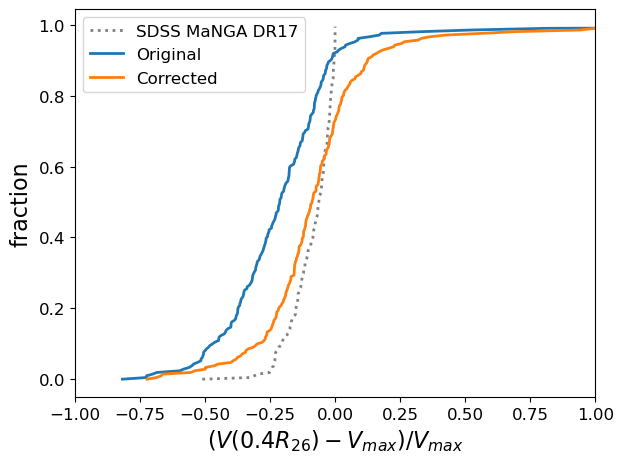

In [304]:
original_x = sorted((SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample])/SGA_MaNGA['Vmax_map'][final_sample])
DESI_y = np.arange(np.sum(final_sample))/np.sum(final_sample)

corrected_x = sorted(corrected_residuals[final_sample]/SGA_MaNGA['Vmax_map'][final_sample])

finite_boolean = np.isfinite(SGA_MaNGA['Vfit_0p4R26'] - SGA_MaNGA['Vmax_map'])
MaNGA_x = sorted((SGA_MaNGA['Vfit_0p4R26'][finite_boolean & final_sample] - SGA_MaNGA['Vmax_map'][finite_boolean & final_sample])/SGA_MaNGA['Vmax_map'][finite_boolean & final_sample])
MaNGA_y = np.arange(np.sum(finite_boolean & final_sample))/np.sum(finite_boolean & final_sample)


plt.figure(tight_layout=True)

plt.plot(MaNGA_x, MaNGA_y, ':', c='gray', linewidth=2, label='SDSS MaNGA DR17')
plt.plot(original_x, DESI_y, c='tab:blue', linewidth=2, label='Original')
plt.plot(corrected_x, DESI_y, c='tab:orange', linewidth=2, label='Corrected')

plt.xlim([-1, 1])

plt.legend()

plt.xlabel('$(V(0.4R_{26}) - V_{max})/V_{max}$', fontsize=16)
plt.ylabel('fraction', fontsize=16);

## How do these residuals depend on the difference in $\phi$?

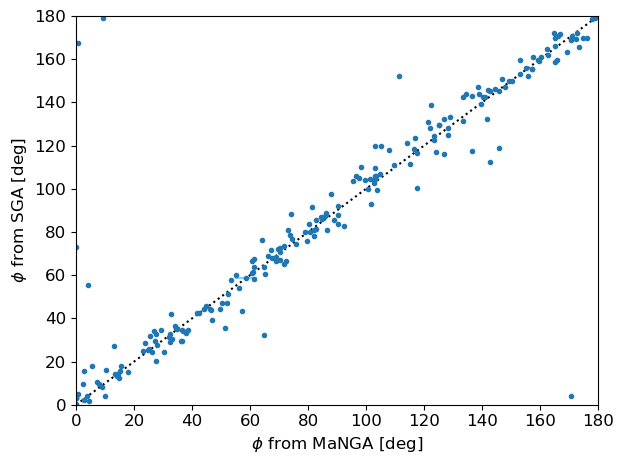

In [305]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['phi_map'][final_sample]%180., SGA_MaNGA['PA'][final_sample], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample], 
             fmt='.', 
             ecolor='lightskyblue')
plt.plot([0,180], [0,180], 'k:')

plt.xlim([0, 180])
plt.ylim([0, 180])

plt.xlabel('$\phi$ from MaNGA [deg]')
plt.ylabel('$\phi$ from SGA [deg]');

In [306]:
SGA_MaNGA['delta_phi'] = SGA_MaNGA['phi_map']%180. - SGA_MaNGA['PA']

SGA_MaNGA['delta_phi'][np.abs(SGA_MaNGA['delta_phi']) >= 90.] = 180. - np.abs(SGA_MaNGA['delta_phi'][np.abs(SGA_MaNGA['delta_phi']) >= 90.])

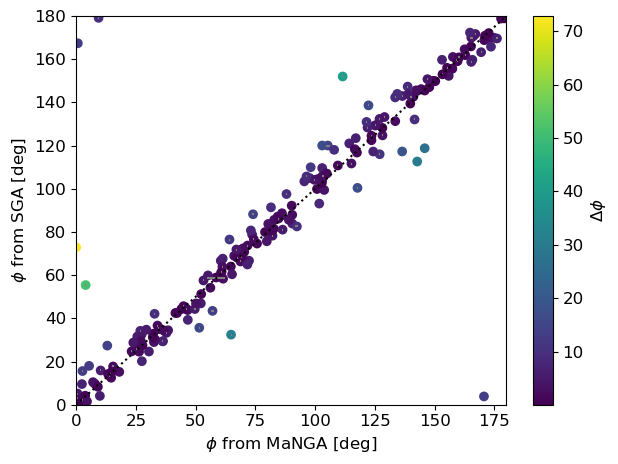

In [307]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_MaNGA['phi_map'][final_sample]%180., SGA_MaNGA['PA'][final_sample], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample], 
             fmt='None',
             ecolor='gray')
plt.scatter(SGA_MaNGA['phi_map'][final_sample]%180., SGA_MaNGA['PA'][final_sample], 
            c=np.abs(SGA_MaNGA['delta_phi'][final_sample]))
plt.plot([0,180], [0,180], 'k:')

plt.xlim([0, 180])
plt.ylim([0, 180])

plt.colorbar(label='$\Delta \phi$')

plt.xlabel('$\phi$ from MaNGA [deg]')
plt.ylabel('$\phi$ from SGA [deg]');

In [308]:
SGA_MaNGA[['plate', 'ifudsgn', 'plateifu', 'SGA_ID', 'BA', 'PA', 'ba_map', 'phi_map', 'delta_phi']][final_sample & (np.abs(SGA_MaNGA['delta_phi']) > 10)]

plate,ifudsgn,plateifu,SGA_ID,BA,PA,ba_map,phi_map,delta_phi
int64,int64,str11,int64,float64,float64,float64,float64,float64
11978,12705,11978-12705,1202544,0.6631917357444763,76.50524139404297,0.667614888803249,64.14564760854712,-12.359593785495846
9093,12704,9093-12704,648466,0.8203313946723938,27.374771118164062,0.8884576416740546,13.026023194485212,-14.34874792367885
9030,3702,9030-3702,636501,0.865577757358551,167.37779235839844,0.9397163422409488,360.7128035008395,13.33501114244109
8609,6101,8609-6101,1106565,0.4389804005622864,55.40464782714844,0.7156102001835813,3.969177357260716,-51.43547046988772
10225,12701,10225-12701,1288898,0.7045849561691284,115.98374938964844,0.6955047148537247,306.97869779834105,10.994948408692608
8158,9101,8158-9101,298203,0.5584912300109863,112.61156463623047,0.7835382503626966,142.6735330725669,30.06196843633643
11866,12703,11866-12703,1176247,0.7389072179794312,109.9643783569336,0.6586140313919,278.109853793831,-11.854524563102586
9866,12701,9866-12701,919302,0.8149380683898926,15.594803810119629,0.9549666562913078,2.6429061822846736,-12.951897627834956
9512,6103,9512-6103,931125,0.49086201190948486,120.02496337890625,0.6930721473274487,285.26350094255497,-14.76146243635128


In [309]:
np.std(SGA_MaNGA['delta_phi'][final_sample])

9.501825498435414

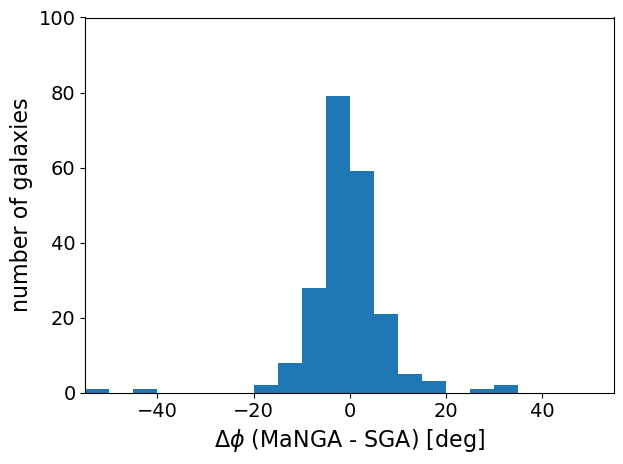

In [315]:
plt.figure(tight_layout=True)

plt.hist(SGA_MaNGA['delta_phi'][final_sample], 
         bins=np.arange(-70, 70, 5))

plt.xlim([-55, 55])
plt.ylim([0, 100])

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

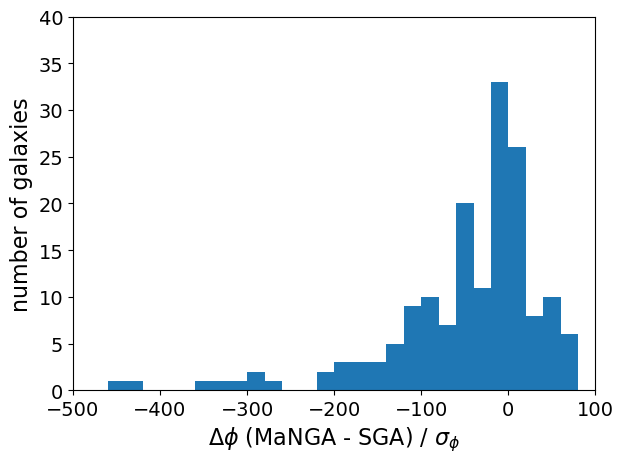

In [318]:
plt.figure(tight_layout=True)

plt.hist(SGA_MaNGA['delta_phi'][final_sample]/SGA_MaNGA['phi_err_map'][final_sample], 
         bins=np.arange(-500, 100, 20))

plt.xlim([-500, 100])
plt.ylim([0, 40])

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) / $\sigma_\phi$', fontsize=16)
plt.ylabel('number of galaxies', fontsize=16);

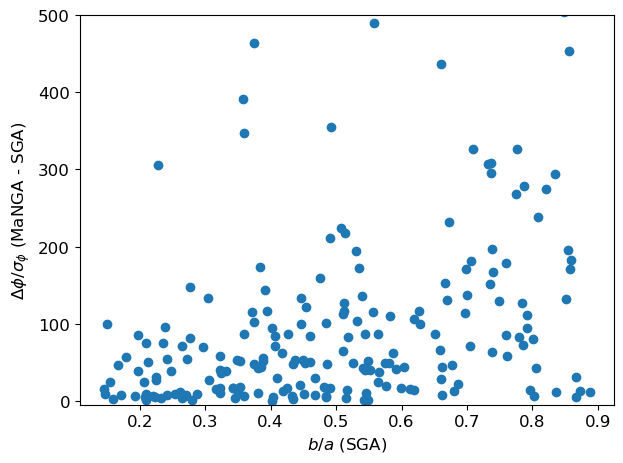

In [319]:
plt.figure(tight_layout=True)

plt.plot(SGA_MaNGA['BA'][final_sample], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample])/SGA_MaNGA['phi_err_map'][final_sample], 
         'o')

plt.ylim([-5, 500])

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta \phi / \sigma_\phi$ (MaNGA - SGA)');

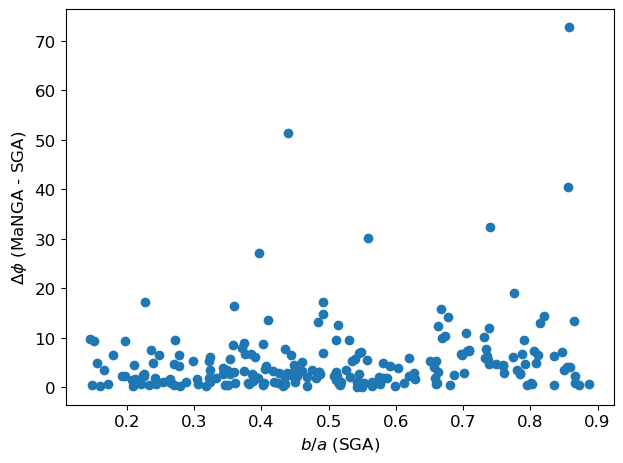

In [320]:
plt.figure(tight_layout=True)

plt.plot(SGA_MaNGA['BA'][final_sample], 
         np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
         'o')

# plt.ylim([-500, 500])

plt.xlabel('$b/a$ (SGA)')
plt.ylabel('$\Delta \phi$ (MaNGA - SGA)');

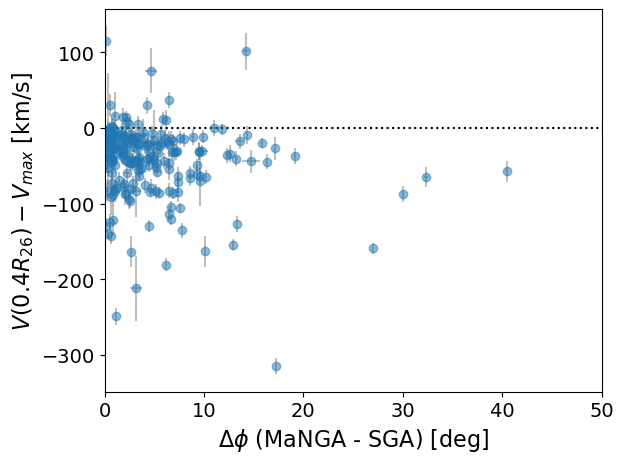

In [321]:
plt.figure(tight_layout=True)

plt.errorbar(np.abs(SGA_MaNGA['delta_phi'][final_sample]), 
             SGA_MaNGA['V_0p4R26'][final_sample] - SGA_MaNGA['Vmax_map'][final_sample], 
             xerr=SGA_MaNGA['phi_err_map'][final_sample], 
             yerr=np.sqrt(SGA_MaNGA['V_0p4R26_ERR'][final_sample]**2 + SGA_MaNGA['Vmax_err_map'][final_sample]**2), 
             fmt='o', 
             alpha=0.5,
             ecolor='gray')
plt.hlines(0, 0., 90., linestyles='dotted', colors='k')

plt.xlim(0, 50)
#plt.ylim(-325, 75)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$\Delta \phi$ (MaNGA - SGA) [deg]', fontsize=16)
plt.ylabel('$V(0.4R_{26}) - V_{max}$ [km/s]', fontsize=16);

#plt.savefig('../Figures/SV/MaNGA_fuji_deltaVmax-vs-deltaPhi_20230823.png', dpi=150);